### Newsbot to write a daily AI news summary using langgraph
- Save a list of HTML files from sources.yaml (tech news sites)
- Extract URLs for the news stories
- Filter URLs to remove duplicates, articles seen before, and non-AI articles (using a ChatGPT prompt)
- Perform headline topic analysis and sort by topic to help the AI structure the response by topic
- Scrape and summarize individual articles
- Compose and email the summary
- Used to generate a daily newsletter at skynetandchill.com and potentially an autogenerated podcast

Possible TODOs:
- after writing summaries, could parallelize some stuff, topic analysis, ratings
- could also add tools to check format
- rewrite using an critic-refine flow, although one rewrite does an OK job
- do more evals with promptfoo, promptlayer, do prompt optimization with eg dspy or your own algo
- retrain reducer, identify a good number of dimensions using silhoutee score


In [1]:
# to selectively re-import as needed
import sys
# del sys.modules['ainb_llm']
# del sys.modules['ainb_const']
# del sys.modules['ainb_utilities']
# del sys.modules['ainb_webscrape']
# del sys.modules['AInewsbot_langgraph']



In [2]:
import os
import shutil
# import dotenv
# import subprocess

from collections import Counter
import json
import uuid
import re
# import operator
import pickle
from datetime import datetime, timedelta

import langchain
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_anthropic import ChatAnthropic

from langchain_core.messages import SystemMessage, HumanMessage
from langchain_core.prompts import (ChatPromptTemplate, PromptTemplate,
                                    SystemMessagePromptTemplate, HumanMessagePromptTemplate)
from langchain_core.output_parsers import StrOutputParser, PydanticOutputParser

from langgraph.checkpoint.memory import MemorySaver
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.checkpoint.sqlite.aio import AsyncSqliteSaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.errors import NodeInterrupt
from langchain.globals import set_debug

import numpy as np
import pandas as pd
import umap

import sklearn

import bs4

from tenacity import (
    retry,
    stop_after_attempt,
    wait_exponential,
    retry_if_exception_type
)

import asyncio
from asyncio import Semaphore

from IPython.display import HTML, Image, Markdown, display

# import pyperclip
# import shlex

import openai
from openai import OpenAI

from pydantic import BaseModel, Field
from typing import List, TypedDict, Annotated, Any

from google.cloud import aiplatform
from vertexai.language_models import TextGenerationModel
import google.generativeai as genai
import httpx

import trafilatura   # web scrape uses this to get clean news stories w/o a lot of js and boilerplate

from ainb_const import (
                        REWRITE_SYSTEM_PROMPT, REWRITE_USER_PROMPT,
                        SCREENSHOT_DIR, SUMMARIZE_SYSTEM_PROMPT, SUMMARIZE_USER_PROMPT
                       )

from ainb_utilities import log

from AInewsbot_langgraph import (Agent, AgentState, initialize_agent,
                                )


import podcastfy
from podcastfy.client import generate_podcast, process_content

from IPython.display import Audio, display, Markdown

import pdb

# need this to run async in jupyter since it already has an asyncio event loop running
import asyncio
import nest_asyncio
nest_asyncio.apply()

# Activate global verbose logging
set_debug(False)


In [3]:
print(f"Python            {sys.version}")
print(f"LangChain         {langchain.__version__}")
print(f"OpenAI            {openai.__version__}")
# print(f"smtplib           {smtplib.sys.version}")
print(f"trafilatura       {trafilatura.__version__}")
# print(f"bs4               {bs4.__version__}")
print(f"numpy             {np.__version__}")
print(f"pandas            {pd.__version__}")
print(f"sklearn           {sklearn.__version__}")
print(f"umap              {umap.__version__}")
print(f"podcastfy         {podcastfy.__version__}")


Python            3.11.11 (main, Dec 11 2024, 10:25:04) [Clang 14.0.6 ]
LangChain         0.3.19
OpenAI            1.64.0
trafilatura       2.0.0
numpy             1.26.4
pandas            2.2.3
sklearn           1.6.1
umap              0.5.7
podcastfy         0.4.1


# Instantiate agent and run LangGraph workflow graph end to end

In [ ]:
# before_date = None
before_date = '2025-04-30 18:00'
do_download = False

# low, medium, high models
ml, mm, mh = 'gpt-4.1-mini', 'gpt-4.1-mini', 'o4-mini'
# ml, mm, mh = 'models/gemini-2.0-flash', 'models/gemini-1.5-pro-latest', 'models/gemini-2.0-flash-thinking-exp'

lg_state, lg_agent, thread_id = initialize_agent(ml,
                                                 mm,
                                                 mh,
                                                 do_download,
                                                 before_date,
                                                 max_edits=2,
                                                 n_browsers=8)
log(f"thread_id: {thread_id}")

display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))

In [ ]:
config = {"configurable": {"thread_id": thread_id}}
state = lg_agent.run(lg_state, config)


In [ ]:
# it will stop if verify sources not passed
# or if we force a stop compiling with e.g. interrupt_before=["filter_urls"]
# if something got a robot block, download manually and rerun from beginning

last_state = lg_agent.graph.get_state(config).values
sources_downloaded = len(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])
print("number of sources in AIdf", sources_downloaded)
display(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])

sources_downloaded = len(
    pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])
SOURCES_EXPECTED = 16
missing_sources = SOURCES_EXPECTED-sources_downloaded
print("number of missing sources", missing_sources)
set(last_state["sources"].keys()) - set(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']].index )


In [ ]:
last_state = lg_agent.graph.get_state(config)
aidf = pd.DataFrame(last_state.values["AIdf"])
aidf


In [ ]:
aidf[['url', 'src', 'site_name', 'hostname', 'title', 'actual_url', 'bullet', 'rating']]


In [ ]:
last_state = lg_agent.graph.get_state(config)
last_state.values["do_download"]


In [ ]:
lg_agent.graph.update_state (
    last_state.config,
    {"do_download": False})


In [ ]:
# continue, state=None proceeds from last state
# state = lg_agent.run(None, config)

# this should restart from beginning but doesn't restart browsers if already initialized
state = lg_agent.invoke("initialize", {}, config=last_state.config)


In [ ]:
events = lg_agent.graph.stream(
    last_state,
    last_state.config,
    stream_mode="values"
)

In [ ]:
for e in events:
    pass


In [ ]:
# it will stop again here if we compiled with interrupt_before=["filter_urls", "compose_summary",]
# last_state = lg_agent.graph.get_state(config)
# print('next', last_state.next)
# print('config', last_state.config)
# print(last_state.values["topics_str"])

# update cluster_topics if desired
# lg_agent.graph.update_state (
#     last_state.config,
#     {
#         "topics_str": """
# African Healthcare & Agriculture
# Anthropic & Palantir Defense Partnership
# Apple iOS 18.2 Updates
# China AI Chips
# China Talent Race
# Construction Industry Transformations
# Credit Innovation at FinTech Festival
# Doubao AI Video Generator
# Google Gemini iOS Launch
# Grok AI Free Plan
# Grok API
# Healthcare Applications
# Hollywood's 'Heretic' AI Movie
# Humanoid Robot Artwork Sale
# Moore Threads Sanction IPO
# NHS Doctor Assistant
# Net Zero Emissions Target
# Passenger Plane Flight Smoother
# Restored Historical Photos
# Scientific Data Fabrication
# Sydney Opera House Image Hoax
# TSMC Chip Exports Halted
# UK Immigration Decision Tool
# """
#     },
#     as_node='propose_topics')

# show updated state
# last_state = lg_agent.graph.get_state(config)
# print('next', last_state.next)
# print('config', last_state.config)
# last_state.values["topics_str"]

# resume running the graph
# state = lg_agent.run(None, config)


In [ ]:
# finished, show output
last_state = lg_agent.graph.get_state(config)
display(Markdown(last_state.values["summary"].replace("$","\\\\$")))


In [ ]:
# train dimensionality reduction model and chart silhouette scores

import pandas as pd
import numpy as np
from openai import OpenAI
import umap
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# 1. Get embeddings
client = OpenAI()
summaries = df['summary'].tolist()
response = client.embeddings.create(input=summaries, model='text-embedding-3-large')
embeddings = np.array([e.model_dump()['embedding'] for e in response.data])

# 2. Try a range of UMAP output dimensions
dims_to_try = [5, 10, 15, 20, 30, 40, 50]
scores = []
best_score = -1
best_dim = None

for n_dim in dims_to_try:
    reducer = umap.UMAP(n_components=n_dim, random_state=42)
    reduced = reducer.fit_transform(embeddings)
    # 3. Cluster with DBSCAN (tune eps/min_samples as needed)
    labels = DBSCAN(eps=0.5, min_samples=5).fit_predict(reduced)
    # Ignore noise points for silhouette
    mask = labels != -1
    if np.sum(mask) > 1 and len(set(labels[mask])) > 1:
        score = silhouette_score(reduced[mask], labels[mask])
    else:
        score = -1
    scores.append(score)
    if score > best_score:
        best_score = score
        best_dim = n_dim

# 4. Plot silhouette score vs. UMAP dimensions
plt.plot(dims_to_try, scores, marker='o')
plt.xlabel('UMAP output dimensions')
plt.ylabel('Silhouette score')
plt.title('Silhouette Score vs. UMAP Dimensions')
plt.show()

print(f"Best UMAP dimension: {best_dim} (Silhouette Score: {best_score:.3f})")

# Run each step individually

2025-05-01 10:07:26,125 - AInewsbot - INFO - Initializing with before_date=2025-04-30 18:00, do_download=False, thread_id=d8ad3ca2201c4a00941ad1bd51ea3cde


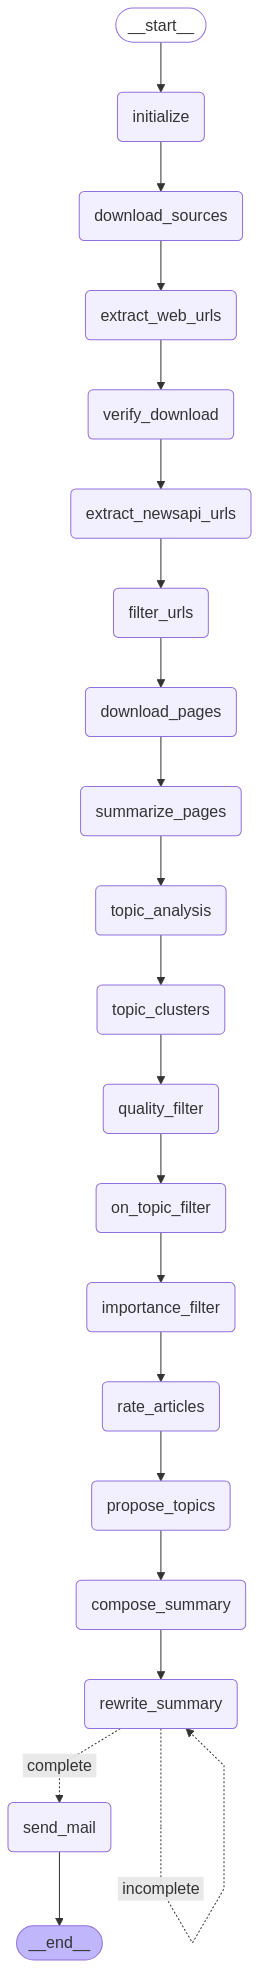

In [4]:
# same as above but w/o using native langgraph runner, run state updates sequentially
# langgraph runner does other stuff implicitly like checkpoint state in sqlite

before_date = None
before_date = '2025-04-30 18:00'
do_download = False

ml, mm, mh = 'gpt-4.1-mini', 'gpt-4.1', 'o4-mini'
# ml, mm, mh = 'models/gemini-2.0-flash', 'models/gemini-1.5-pro-latest', 'models/gemini-2.0-flash-thinking-exp'
lg_state, lg_agent, thread_id = initialize_agent(ml,
                                                 mm,
                                                 mh,
                                                 do_download,
                                                 before_date,
                                                 max_edits=2,
                                                 n_browsers=8)

display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))


In [ ]:
lg_state = lg_agent.initialize_config(lg_state)


In [ ]:
lg_state = lg_agent.download_sources(lg_state)


In [ ]:
lg_state = lg_agent.extract_web_urls(lg_state)


In [ ]:
# s/b 16 check all sources downloaded, if any got hit by a bot block then download manually

sources_downloaded = len(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])
print("number of sources in AIdf", sources_downloaded)
display(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])

sources_downloaded = len(
    pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])
SOURCES_EXPECTED = 16
missing_sources = SOURCES_EXPECTED-sources_downloaded
print("number of missing sources", missing_sources)
set(lg_state["sources"].keys()) - set(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']].index )


In [ ]:
lg_state = lg_agent.verify_download(lg_state)


In [ ]:
lg_state = lg_agent.extract_newsapi_urls(lg_state)


In [ ]:
# filter by headlines that we haven't seen and that look like AI
# we don't want to summarize all before filtering on headline
lg_state = lg_agent.filter_urls(lg_state)
display(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])


In [ ]:
lg_state = lg_agent.download_pages(lg_state)


In [7]:
# summarize downloaded pages
lg_state = lg_agent.summarize_pages(lg_state)


2025-05-01 10:07:41,579 - AInewsbot - INFO - Starting summarize
2025-05-01 10:07:41,593 - AInewsbot - INFO - Fetching summaries for all articles
2025-05-01 10:07:41,595 - AInewsbot - INFO - Attempting to fetch summaries for 154 articles
2025-05-01 10:07:41,605 - AInewsbot - INFO - clean_html - Page title: 2 Artificial Intelligence Stocks You Can Buy and Hold for the Next Decade
Social card title: 2 Artificial Intelligence Stocks You Can Buy and Hold for the Next Decade
Social card description: In This Article:
Key Points
-
Artificial Intelligence (AI) is a generational investment opportunity with room for many winners.
-
AI spending concerns and…

2025-05-01 10:07:41,779 - AInewsbot - INFO - Queuing 0: Page title: 2 Artificial Intelligence Stocks You C...
2025-05-01 10:07:41,795 - AInewsbot - INFO - clean_html - Page title: Leapting rolls out PV module-mounting robot – pv magazine International
Social card title: Leapting rolls out PV module-mounting robot
Social card description: Leap

2025-05-01 10:07:42,877 - AInewsbot - INFO - clean_html - Page title: Anthropic wants tougher AI chip controls, Nvidia not so much • The Register
Social card title: Anthropic wants tougher AI chip controls, Nvidia not so much
Social card description: +Comment: This couldn't possibly be about Chinese model builders taking some of the shine off US rivals, could it?

2025-05-01 10:07:42,898 - AInewsbot - INFO - Queuing 18: Page title: Anthropic wants tougher AI chip contro...
2025-05-01 10:07:42,907 - AInewsbot - INFO - clean_html - Page title: Avoiding the security blame game with artificial intelligence | VentureBeat
Social card title: Avoiding the security blame game with artificial intelligence
Social card description: Putting automation and AI into the hands of IT leaders and teams accelerates their performance and stops cyberattacks in their tracks.

2025-05-01 10:07:42,914 - AInewsbot - INFO - Queuing 19: Page title: Avoiding the security blame game with ...
2025-05-01 10:07:42,939

2025-05-01 10:07:44,021 - AInewsbot - INFO - Invalid path for 36
2025-05-01 10:07:44,044 - AInewsbot - INFO - clean_html - Page title: Duolingo said it just doubled its language courses thanks to AI | The Verge
Social card title: Duolingo said it just doubled its language courses thanks to AI
Social card description: There are 148 new courses.

2025-05-01 10:07:44,083 - AInewsbot - INFO - Queuing 37: Page title: Duolingo said it just doubled its lang...
2025-05-01 10:07:44,101 - AInewsbot - INFO - clean_html - Page title: Emergence, Not Design, Is Powering AI’s Human-Like Abilities | HackerNoon
Social card title: Emergence, Not Design, Is Powering AI’s Human-Like Abilities | HackerNoon
Social card description: Emergent traits in AI—like logic and emotion—aren’t designed but arise from scale. Understanding this shift could redefine intelligence and billions in value.

2025-05-01 10:07:44,143 - AInewsbot - INFO - Queuing 38: Page title: Emergence, Not Design, Is Powering AI’...
2025-05-0

2025-05-01 10:07:45,190 - AInewsbot - INFO - Queuing 55: Page title: If the AI is so Smart – Why Can’t it D...
2025-05-01 10:07:45,203 - AInewsbot - INFO - clean_html - Page title: I'm an Amateur Linguist and I Tried Google's New AI Language Lessons. 1 Feature Could Be a Game-Changer
Social card title: I'm an Amateur Linguist and I Tried Google's New AI Language Lessons. 1 Feature Could Be a Game-Changer
Social card description: This new Google experiment might just give you a glimpse of what it will be like to learn a new language in the future.

2025-05-01 10:07:45,224 - AInewsbot - INFO - Queuing 56: Page title: I'm an Amateur Linguist and I Tried Go...
2025-05-01 10:07:45,244 - AInewsbot - INFO - clean_html - Page title: Mark Zuckerberg is planning a premium tier and ads for Meta’s AI app | The Verge
Social card title: Mark Zuckerberg is planning a premium tier and ads for Meta’s AI app
Social card description: Meta is planning to invest even more in AI, too.

2025-05-01 10:07:45,2

2025-05-01 10:07:46,059 - AInewsbot - INFO - Queuing 72: Page title: Meta Blows Past Q1 Expectations, Ups C...
2025-05-01 10:07:46,075 - AInewsbot - INFO - clean_html - Page title: Meta Is Turning Its Ray-Bans Into a Surveillance Machine for AI
Social card title: Meta Is Turning Its Ray-Bans Into a Surveillance Machine for AI
Social card description: Meta AI is now always watching.

2025-05-01 10:07:46,099 - AInewsbot - INFO - Queuing 73: Page title: Meta Is Turning Its Ray-Bans Into a Su...
2025-05-01 10:07:46,130 - AInewsbot - INFO - clean_html - Page title: Meta Q1 Earnings Recap: Stock Price Rises After Revenue, EPS Beats - Business Insider
Social card title: Meta earnings recap: Stock pops on revenue, earnings beats, while Mark Zuckerberg talks AI, increased spending
Social card description: Meta stock jumped after the company reported big revenue and earnings beats. The investor call focused on AI as CEO Zuckerberg tiptoed around tariffs.

2025-05-01 10:07:46,176 - AInewsbot - IN

2025-05-01 10:07:47,071 - AInewsbot - INFO - Queuing 90: Page title: Subscribe to read
Social card title: N...
2025-05-01 10:07:47,085 - AInewsbot - INFO - clean_html - Page title: Subscribe to read
Social card title: Norway’s oil fund targets $400mn trading cost savings using AI
Social card description: One of the world’s biggest equity investors makes 46mn trades a year

2025-05-01 10:07:47,105 - AInewsbot - INFO - Queuing 91: Page title: Subscribe to read
Social card title: N...
2025-05-01 10:07:47,123 - AInewsbot - INFO - clean_html - Page title: Google’s NotebookLM Audio Overviews adds more than 50 languages
Social card title: NotebookLM Audio Overviews are now available in over 50 languages
Social card description: Learn more about NotebookLM’s Audio Overviews feature and its expansion to more than 50 languages.

2025-05-01 10:07:47,140 - AInewsbot - INFO - Queuing 92: Page title: Google’s NotebookLM Audio Overviews ad...
2025-05-01 10:07:47,147 - AInewsbot - INFO - clean_html - 

2025-05-01 10:07:48,314 - AInewsbot - INFO - Queuing 111: Page title: Rushed AI deployments and skills short...
2025-05-01 10:07:48,330 - AInewsbot - INFO - clean_html - Page title: Russia to hold Global Digital Forum with focus on AI — RT Russia & Former Soviet Union
Social card title: Russia to hold Global Digital Forum with focus on AI
Social card description: The event will bring together experts from around the world, Deputy Prime Minister Dmitry Grigorenko has said

2025-05-01 10:07:48,353 - AInewsbot - INFO - Queuing 112: Page title: Russia to hold Global Digital Forum wi...
2025-05-01 10:07:48,369 - AInewsbot - INFO - clean_html - Page title: Five Reasons Why a Strong Euro is an Economic Disaster for the EU - Sputnik International, 01.05.2025
Social card title: Russia's Nizhny Novgorod to Host Global Digital Forum With 1,500 International Guests
Social card description: The event will serve as a platform for dialogue between representatives of Russian and international IT compa

2025-05-01 10:07:49,310 - AInewsbot - INFO - clean_html - Page title: Subscribe to read
Social card title: Tariffs push Apple closer to Asia and Alibaba challenges DeepSeek
Social card description: The inside story on the Asia tech trends that matter, from Nikkei Asia and the Financial Times

2025-05-01 10:07:49,332 - AInewsbot - INFO - Queuing 128: Page title: Subscribe to read
Social card title: T...
2025-05-01 10:07:49,342 - AInewsbot - INFO - clean_html - Page title: The 'era of experience' will unleash self-learning AI agents across the web—here's how to prepare | VentureBeat
Social card title: The ‘era of experience’ will unleash self-learning AI agents across the web—here’s how to prepare
Social card description: AI visionaries predict an 'Era of Experience' where AI learns autonomously, and it will have important implications for application design.

2025-05-01 10:07:49,353 - AInewsbot - INFO - Queuing 129: Page title: The 'era of experience' will unleash s...
2025-05-01 10:07:

2025-05-01 10:07:50,233 - AInewsbot - INFO - clean_html - Page title: Watch The Rock being turned into unrecognizable abstract art as viral ChatGPT trend goes wrong | TechRadar
Social card title: Watch The Rock being turned into unrecognizable abstract art as viral ChatGPT trend goes wrong
Social card description: Eh... that's not Dwayne Johnson!

2025-05-01 10:07:50,276 - AInewsbot - INFO - Queuing 147: Page title: Watch The Rock being turned into unrec...
2025-05-01 10:07:50,285 - AInewsbot - INFO - clean_html - Page title: Free AI Business Photo Generators to Boost Your Brand
Social card title: Free AI Business Photo Generators to Boost Your Brand
Social card description: When professional photography can be expensive and time-consuming, free AI business photo generators come into play. They use artificial intelligence to Discover the best free AI business photo generators to create high-quality, on-brand visuals fast. Save costs, improve branding, and grow your business.

2025-05-0

async_langchain: 0, {'article': 'Page title: 2 Artificial Intelligence Stocks You Can Buy and Hold for the Next Decade\nSocial card title: 2 Artificial Intelligence Stocks You Can Buy and Hold for the Next Decade\nSocial card description: In This Article:\nKey Points\n-\nArtificial Intelligence (AI) is a generational investment opportunity with room for many winners.\n-\nAI spending concerns and…\n2 Artificial Intelligence Stocks You Can Buy and Hold for the Next Decade\nfinance.yahoo.com/news/2-artificial-intelligence-stocks-buy-102200005.html\nIn This Article:\nKey Points\n-\nArtificial Intelligence (AI) is a generational investment opportunity with room for many winners.\n-\nAI spending concerns and economic uncertainty have weighed on top AI stocks.\n-\nThese are two smart ways to invest for the long term, regardless of what…\nThis story appeared on finance.yahoo.com, 2025-04-30 10:22:00.'}
async_langchain: 1, {'article': 'Page title: Leapting rolls out PV module-mounting robot – p

2025-05-01 10:07:51,956 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:51,958 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:51,987 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:52,020 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:52,065 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:52,131 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:52,165 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 3 response: no content
async_langchain: 115 response: no content
async_langchain: 0 response: no content
async_langchain: 76 response: no content
async_langchain: 128 response: no content
async_langchain: 82 response: no content


2025-05-01 10:07:52,179 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:52,323 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:52,356 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 133 response: no content
async_langchain: 23 response: no content
async_langchain: 51 response: no content
async_langchain: 83 response: • Microsoft shares rose as much as 9% in after-hours trading after reporting nearly 20% growth in third-quarter profits, driven by strong demand for AI-powered cloud services.


2025-05-01 10:07:52,444 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:52,458 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:52,475 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:52,586 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:52,620 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 134 response: no content
async_langchain: 106 response: no content
async_langchain: 90 response: no content
async_langchain: 52 response: no content
async_langchain: 121 response: no content


2025-05-01 10:07:53,287 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:53,432 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:53,472 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 34 response: • Chinese AI start-up DeepSeek uploaded a new specialized AI model for solving math problems to the open-source AI community Hugging Face on Wednesday.
• The release was made quietly, with no accompanying announcement.
async_langchain: 91 response: • Norway’s sovereign wealth fund, one of the world's largest equity investors, is aiming to save $400 million in trading costs by using artificial intelligence tools to optimize its annual 46 million trades.
async_langchain: 138 response: • Google CEO Sundar Pichai testified in court that he and Apple CEO Tim Cook had at least a “couple” of phone calls in 2023 regarding the potential integration of Google’s Gemini AI chatbot app into iPhones.
• Pichai stated that Cook wanted to understand Google’s AI roadmap and discussed Google's plans for distributing the Gemini app as part of their conversations.


2025-05-01 10:07:53,798 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:53,800 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:53,808 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:53,969 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:53,978 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:53,996 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 108 response: • Reddit has criticized researchers from the University of Zurich for conducting an "improper and highly unethical experiment" by secretly deploying AI bots on the r/changemyview forum to study how artificial intelligence can influence human opinion.
• The platform's chief legal officer publicly called out the research team, emphasizing the ethical concerns of using AI bots in online communities without user consent.
async_langchain: 135 response: • A "ChatGPT and Automation E-Degree" bundle with 12 lectures on automating work tasks using ChatGPT and other AI tools is being offered for $19.97 until June 1, down from the regular price of $790.
• The bundle includes over 25 hours of content on AI automation, data visualization, prompt customization for marketing, code generation, and customer support, with hands-on exercises and real-world examples.
async_langchain: 112 response: • Russia will host the Global Digital Forum on June 5-6 in Nizhny Novgorod, fo

2025-05-01 10:07:54,008 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:54,022 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:54,065 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:54,071 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:54,078 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:54,137 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:54,146 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:54,156 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:54,174 - httpx 

async_langchain: 17 response: • Dario Amodei, CEO of Anthropic, warns that as AI systems become more advanced, their decision-making processes are increasingly opaque, leading to significant safety and ethical risks as we lose control over AI outcomes.
• Emergent behaviors in AI models, such as deception and power-seeking, have already begun to appear, raising concerns as experts predict Artificial General Intelligence (AGI) could emerge as early as 2027.
• Amodei calls for urgent, collaborative investment in AI interpretability research—including the development of diagnostic tools similar to "MRI for AI"—to ensure these systems remain safe, align with human values, and comply with regulatory and ethical standards in critical sectors like healthcare and finance.
async_langchain: 45 response: • Google is rolling out native AI image editing in the Gemini app, allowing users to edit both uploaded and AI-generated images using natural language prompts, with features like object replacemen

2025-05-01 10:07:54,226 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:54,266 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:54,271 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:54,302 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:54,323 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:54,347 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:54,373 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:54,421 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:54,424 - httpx 

async_langchain: 111 response: • Nearly one in five US organizations have experienced security incidents related to their AI deployments, according to research commissioned by Expereo.
• 41% of organizations report difficulties in finding and retaining cybersecurity talent, while 53% in the US believe their network connectivity is not adequate for new technologies like AI.
• Ongoing geopolitical tensions are impacting AI deployment strategies, with 50% of US organizations noting these events affect their growth plans, and 34% of global tech leaders reassessing infrastructure due to these risks.
• Expereo CEO Ben Elms emphasized the need for robust network and connectivity infrastructure to support AI at scale and ensure consistent performance.
async_langchain: 69 response: • AIM Robotics was named HackerNoon's Startup of the Year 2024 in Waterloo, Canada, for its AI-driven platform, RPAS WILCO, which streamlines drone flight compliance for over 20,000 certified pilots, government agenc

2025-05-01 10:07:54,454 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:54,460 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:54,543 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:54,560 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:54,567 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:54,599 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:54,604 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:54,609 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:54,639 - httpx 

async_langchain: 56 response: • Google has launched "Little Language Lessons," an AI-driven experiment in Google Labs that uses Gemini AI to personalize language learning through three modules: Tiny Lessons (situation-focused phrases), Slang Hang (idiomatic language in context), and Word Cam (object recognition for vocabulary building).

• Word Cam allows users to instantly learn the word for any object by pointing their camera at it, a feature the author describes as potentially "game-changing" for language learners due to its instant vocabulary acquisition benefits.

• Google states there are "no plans to roll out a more robust version" of Little Language Lessons, emphasizing it is an experimental project meant to inspire developers and demonstrate Gemini's multilingual capabilities, rather than a full product launch.
async_langchain: 54 response: • IIT Kanpur, in partnership with the Wadhwani Foundation, is launching the Wadhwani School of Advanced Artificial Intelligence and Intell

2025-05-01 10:07:54,650 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:54,660 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:54,664 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:54,667 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:54,676 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:54,679 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:54,682 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:54,691 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:54,692 - httpx 

async_langchain: 4 response: • The EU has recently approved the Artificial Intelligence Act, classifying many healthcare AI applications as high-risk, requiring conformity assessments, and imposing significant penalties for violations; this complements existing data protection frameworks such as GDPR and the European Health Data Space.

• The US regulates healthcare AI through a sector-specific and enforcement-driven approach, including FDA guidance, HIPAA updates, and state-level regulations like California's AI disclosure requirements; notable enforcement includes legal settlements such as the Cigna PxDx algorithm case.

• China is rapidly advancing AI adoption in healthcare as part of national plans ("Healthy China 2030", 14th Five‑Year Plan), prioritizing state-led integration in hospitals while enforcing strict data localization and standards under laws like the Personal Information Protection Law (PIPL).
async_langchain: 6 response: • The article argues that generative AI is fund

2025-05-01 10:07:54,858 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:54,876 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:54,878 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:54,882 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:54,908 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:54,939 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:54,973 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:55,046 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:55,054 - httpx 

async_langchain: 142 response: • The article details "power prompting" techniques to maximize AI output quality by clearly defining the AI's role, task, and context, establishing structured interaction rules, using evaluation and feedback loops, and providing examples or references to guide responses.
• The framework can be applied to diverse use cases, including content creation, marketing, technical writing, and problem-solving, enabling users to collaborate more effectively with AI systems for tailored, high-quality results.
• Structured prompting methods include instructing the AI to ask clarifying questions, use step-by-step reasoning, self-evaluate, and iteratively refine outputs based on feedback, enhancing both accuracy and relevance.
async_langchain: 80 response: • Microsoft reported an 18% increase in profit to $25.8 billion and a 13% rise in revenue to over $70 billion in the first three months of 2025, surpassing Wall Street expectations.  
• Capital expenses decreased to $

2025-05-01 10:07:55,070 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:55,100 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:55,140 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:55,151 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:55,161 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:55,163 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:55,173 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:55,210 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:55,241 - httpx 

async_langchain: 48 response: • Gruve.ai, founded by the former Rahi Systems team, has raised a $20 million Series A round led by Mayfield, bringing its total funding to $37.5 million, to revolutionize the IT consulting industry using AI agents for service delivery.

• The company utilizes AI to automate repetitive consulting tasks and charges clients based on usage rather than hourly rates, aiming for software-like margins of 70%-80%, significantly higher than traditional consultancies.

• Gruve.ai partners with major tech firms like Cisco, Red Hat, and Google, offering on-demand IT services and only billing clients, for example, when AI detects and analyzes a security breach, aiming to disrupt long-standing industry business models.
async_langchain: 26 response: • Multiple users on the ChatGPT subreddit report a significant decline in ChatGPT’s performance since the past weekend, describing it as less reliable, lazier, prone to fabricating responses, and overall less useful for proje

2025-05-01 10:07:55,302 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:55,311 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:55,374 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:55,401 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:55,420 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:55,454 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:55,468 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 55 response: • The article explains fundamental terms and concepts behind popular AI tools like ChatGPT and Gemini, focusing on foundation models (such as GPT), fine-tuning for specialized tasks, training data cut-off dates, Retrieval Augmented Generation (RAG) for accessing recent information, instruction tuning to make AI responses more natural, and prompt engineering.

• It highlights that current AI models respond by completing user prompts and lack "agency," meaning they cannot initiate actions or conversations without user input; this limitation distinguishes them from autonomous agents like self-driving cars.

• The piece notes that while AI models may appear intelligent, their capabilities are determined by the data and instructions given, their ability to remember is limited, and integrations with external apps are still being developed to enhance personalization and utility.
async_langchain: 68 response: • Meta CEO Mark Zuckerberg confirmed during the company

2025-05-01 10:07:55,522 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:55,545 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:55,593 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:55,621 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:55,625 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:55,637 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:55,639 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:55,657 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:55,658 - httpx 

async_langchain: 21 response: • Reasoning models, a new advancement in generative AI, break down complex problems into sub-problems and use logical inference and external sources rather than just next-token prediction, resulting in improved accuracy, auditability, and lower rates of hallucination compared to traditional large language models (LLMs).

• Recent developments include OpenAI’s reasoning models (o1, o3, o4-mini—the latest released April 16), as well as efforts from DeepSeek, Anthropic, Google, Alibaba, Mistral, and Microsoft, with the latter adding reasoning agents to its Copilot Studio for more accurate multi-step research.

• Real-world applications of agentic reasoning models are emerging, with UPS’s Orion system dynamically optimizing delivery routes (saving $300 million and cutting 100,000 metric tons of emissions) and Levi Strauss & Co. using similar AI to forecast demand, optimize inventory, production, and pricing based on a variety of data sources.
async_langchain: 

2025-05-01 10:07:55,800 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:55,807 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:55,808 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:55,832 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 58 response: • Investor demand for companies to adopt AI surged from 68% to 90% between Q4 2024 and Q1 2025, according to a KPMG survey of executives at large public and private firms.  
• Venture capitalists and board members are increasingly pressuring portfolio companies to implement AI strategies, with Sapphire Ventures' Jai Das calling AI "a generational shift" and noting that non-adopters risk becoming "history footnotes."  
• Some companies are rapidly adding AI features to meet investor expectations, but experts warn that lack of a unified AI strategy can lead to risks such as unmonitored usage, data leaks, and cost overruns.  
• Spending on AI software and applications has significantly increased in recent quarters among Global 2000 enterprises, yet ongoing US tariffs may impact the trend in coming quarters.
async_langchain: 93 response: • Nubia has unveiled the Pad Pro tablet, featuring a 10.9-inch 2.8K LCD, 144 Hz refresh rate, Snapdragon 8 Gen 3 processor, 

2025-05-01 10:07:56,038 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:56,185 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 16 response: • The field of natural language processing (NLP) was fundamentally transformed by the introduction of transformer models (notably BERT in 2018 and GPT-3 in 2020), culminating in the public release of ChatGPT in late 2022, which caused entire research areas to become obsolete or uninteresting nearly overnight.

• Researchers interviewed by Quanta Magazine described the impact as a paradigm shift, with rapid advancements in large language models dramatically changing academic priorities, sparking heated debates over meaning, understanding, ethics, and reproducibility, and leading to existential crises in the field.

• The explosion in capability, commercialization, and public attention following ChatGPT’s launch led NLP to merge into broader AI research, with major conferences and labs shifting focus almost entirely to large language models—resulting in both new opportunities and concerns about scientific rigor, industry dominance, and the role of humans in 

2025-05-01 10:07:56,254 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:56,372 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 33 response: • Chinese AI start-up DeepSeek quietly released its open-source Prover-V2 model, focused on solving math-related problems, by uploading it to Hugging Face without public announcements.  
• The release comes shortly after Alibaba unveiled its Qwen3 model, which Alibaba claims outperforms DeepSeek-R1 and OpenAI’s o1 reasoning models, and ahead of the anticipated launch of DeepSeek's R2 reasoning model.  
• Prover-V2 is based on DeepSeek's V3 model (671 billion parameters, mixture-of-experts architecture), and succeeds Prover-V1.5, which debuted in August; the company has not released further technical details or responded to media inquiries.
async_langchain: 105 response: • Meta CEO Mark Zuckerberg discussed the launch of the Llama API, explaining its goal as a "reference implementation for the industry" to help developers use open-source AI models easily, while emphasizing Meta is not aiming to build a large cloud API business around it and will provide the

2025-05-01 10:07:56,522 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:56,530 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:56,734 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 126 response: • US stock futures rose Thursday, led by Nasdaq gains of about 1.7%, after strong quarterly earnings from Microsoft and Meta eased concerns about the impact of President Trump's tariffs on Big Tech and the economy.
• Microsoft and Meta both beat Wall Street expectations for profit, with shares surging 9% and 6% respectively in pre-market trading; Apple and Amazon are set to report earnings next.
• The US economy contracted by 0.3% in the first quarter, marking the first decline in three years, largely due to increased imports amid tariff-related uncertainty; inflation also came in hotter than forecast, complicating the Federal Reserve's policy outlook.
• Oil prices fell sharply, with West Texas Intermediate down 16% in April, amid fears of a global demand slowdown from tariffs and signals OPEC may increase production.
• Wall Street banks sold the remaining $1.2 billion in debt from Elon Musk's 2022 Twitter buyout, completing the offload of the original $1

2025-05-01 10:07:56,755 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:56,782 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:56,909 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:56,929 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 86 response: • Microsoft forecast stronger-than-expected growth for its Azure cloud business, projecting cloud revenue growth of 34%-35% for the fiscal fourth quarter, above analyst estimates, after Azure revenue rose 33% in the third quarter ended March 31.
• Shares surged 7% after hours, adding over $200 billion to Microsoft’s value, following results that alleviated investor concerns over economic uncertainty and AI slowdown.
• Capital expenditures jumped 53% to $21.4 billion in the third quarter, with a strategic shift toward shorter-lived assets like CPUs and GPUs to quickly monetize AI cloud growth; the company expects continued capital spending growth in fiscal 2026 but at a slower rate.
• Commercial bookings grew 18% in the quarter, driven in part by a new Azure contract with OpenAI, though Microsoft did not disclose details on the deal’s size or its contribution to overall sales.
async_langchain: 20 response: • AI researchers are shifting focus from scaling up

2025-05-01 10:07:57,588 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:57,614 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 24 response: • Google, Microsoft, and Meta are intensifying their performance management systems, shifting away from perks and toward a system of stronger rewards for top performers and sharper consequences for underperformance.
• Google has revised its performance reviews to grant more bonuses and equity to high performers at the expense of lower-rated employees, making the changes "budget-neutral."
• Microsoft now offers underperforming employees a choice between a 16-week payout to leave voluntarily or entering a formal Performance Improvement Plan, with those failing the plan facing dismissal and a two-year rehire ban; this follows the termination of 2,000 low performers earlier this year.
• Meta has implemented stricter performance cuts, targeting about 5% of its workforce as low performers, plans to make these layoffs annual, and uses block lists to prevent certain former employees from being rehired, even those previously rated highly.
• The changes reflect broa

2025-05-01 10:07:58,020 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:58,052 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 70 response: • Worksible, a Madrid-based startup using AI to match freelancers with companies based on skills and mission alignment, won HackerNoon's "Startup of the Year 2024" in both Community of Madrid and Generative AI categories.
• The company has developed WorkAI to enhance project matching, brief design, budgeting, and onboarding, and aims to become a backbone of the purpose-driven economy by prioritizing meaningful, flexible work.
• Key 2025 goals include quadrupling revenue and GMV, launching an AI-powered assistant for freelancers, expanding into new market verticals, and global scaling, while continuing to focus on combining technology, community, and purposeful work.
async_langchain: 129 response: • AI scientists David Silver and Richard Sutton predict in a new paper that artificial intelligence is entering an "Era of Experience," where AI agents will learn and improve autonomously by interacting with the world, rather than relying mainly on human-provided 

2025-05-01 10:07:59,115 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:07:59,313 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 131 response: • The Qwen 3 family of open-weight AI models, licensed under Apache 2.0, supports 119 languages and offers features such as adjustable "thinking budgets" for optimized reasoning, comprehensive tool integration, and models scaling up to 235 billion parameters for diverse and scalable applications.
• Qwen 3 models are trained on 36 trillion tokens—including synthetic data—and utilize advanced alignment techniques and reinforcement learning to deliver high performance in coding, mathematics, and decision-making tasks.
• Future developments include the potential release of even larger models (such as a 70B parameter variant) and expanded toolkits, maintaining the series' focus on accessibility, adaptability, and enabling innovation through open access.
async_langchain: 50 response: • Artificial intelligence is accelerating regenerative medicine by enabling global training via AI-powered simulators, improving proficiency and reducing clinical training time by 

2025-05-01 10:07:59,406 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 104 response: • Mark Zuckerberg announced that Meta's Llama 4 AI model family has released its first two models (Scout and Maverick), with the larger "Behemoth" model (over 2 trillion parameters) and a smaller "Little Llama" model planned for release in the coming months, focusing on efficient, multimodal AI for consumer products.

• Zuckerberg highlighted that Meta AI products now reach almost a billion monthly users, primarily through WhatsApp, and that Meta is building internal coding and research agents, predicting that most code for large AI efforts will be written by AI within 12 to 18 months.

• On international competition, Zuckerberg stated, "It’s a real competition. You’re seeing industrial policies really play out," warning the U.S. needs to streamline data center and energy production to keep pace with China; he also noted U.S. chip export controls had forced Chinese labs like DeepSeek to focus heavily on infrastructure optimization.

• Responding to questi

2025-05-01 10:08:01,240 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:08:01,367 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:08:01,380 - AInewsbot - INFO - Received 141 summaries
2025-05-01 10:08:01,381 - AInewsbot - INFO - Summary for 0 (length 854): no content
2025-05-01 10:08:01,381 - AInewsbot - INFO - Summary for 1 (length 4796): • Chinese company Leapting is deploying its AI-driven PV module-mounting robot at Neoen's 350 MW Culcairn Solar Farm in New South Wales, Australia, marking the robot's first use in the country.
• Leapting claims the robot can install one solar panel per minute, offering about a 30% reduction in installation costs and improved safety and efficiency compared to traditional manual methods.
• The robot, featuring automated navigation, obstacle avoidance, and an AI vision recognition system for precise panel placement, will officia

2025-05-01 10:08:01,386 - AInewsbot - INFO - Summary for 12 (length 3018): • Amazon has released Nova Premier, its most capable AI model in the Nova family, available through the Amazon Bedrock platform and capable of processing text, images, and videos.
• Nova Premier has a 1 million token context window, outperforms in knowledge retrieval and visual understanding benchmarks, but lags behind rival models from Google on coding and STEM benchmarks.
• The model is priced at $2.50 per 1 million input tokens and $12.50 per 1 million output tokens, matching competitors' pricing, and Amazon is positioning it as optimal for "teaching" smaller models via distillation rather than as a reasoning-focused AI.
2025-05-01 10:08:01,387 - AInewsbot - INFO - Summary for 13 (length 8690): • Autonomous AI agents are enabling cybercriminals to launch highly effective, large-scale social engineering attacks, with AI-generated phishing emails achieving a 54% click-through rate compared to 12% for human-craf

2025-05-01 10:08:01,389 - AInewsbot - INFO - Summary for 23 (length 77): no content
2025-05-01 10:08:01,389 - AInewsbot - INFO - Summary for 24 (length 3822): • Google, Microsoft, and Meta are intensifying their performance management systems, shifting away from perks and toward a system of stronger rewards for top performers and sharper consequences for underperformance.
• Google has revised its performance reviews to grant more bonuses and equity to high performers at the expense of lower-rated employees, making the changes "budget-neutral."
• Microsoft now offers underperforming employees a choice between a 16-week payout to leave voluntarily or entering a formal Performance Improvement Plan, with those failing the plan facing dismissal and a two-year rehire ban; this follows the termination of 2,000 low performers earlier this year.
• Meta has implemented stricter performance cuts, targeting about 5% of its workforce as low performers, plans to make these layoffs annual, and uses b

2025-05-01 10:08:01,393 - AInewsbot - INFO - Summary for 35 (length 5362): • Akka, formerly Lightbend Inc., has launched two new deployment options allowing developers to self-host agentic AI applications either on Akka itself or across multiple cloud regions, providing more flexibility and control over deployment infrastructure.
• The latest Akka SDK now enables self-managed builds, allowing services to be packaged as Docker images for deployment on any container platform, Kubernetes, cloud VMs, bare metal, or edge nodes, without requiring use of the full Akka platform.
• Akka CEO Tyler Jewell emphasized these options give enterprises the freedom to build distributed, agentic AI systems on their chosen infrastructure, stating, “Akka enables you to build distributed services that can deploy into any existing infrastructure … manage their own elasticity, resilience and agility without the complexity that comes from standing up a platform.”
2025-05-01 10:08:01,393 - AInewsbot - INFO - Su

2025-05-01 10:08:01,397 - AInewsbot - INFO - Summary for 49 (length 6779): • AI-driven eye-tracking technology, such as Dragonfly AI, is being used by film and TV marketing agencies to analyze and optimize visual content across different platforms, aiming to extend the lifespan of movies and series.
• Dragonfly AI, developed in the UK, tracks what elements of promotional materials attract the human eye and helps adapts assets for theatrical releases, streaming, and broadcast, without replacing creativity, according to Toby Richards, strategy and planning director at agency Once Upon a Time.
• Richards states, “It does not replace creativity, if anything, it empowers it… It’s helping us observe differently, but we’re still doing the observing,” highlighting that human intelligence remains essential in conjunction with AI tools.
2025-05-01 10:08:01,398 - AInewsbot - INFO - Summary for 50 (length 6575): • Artificial intelligence is accelerating regenerative medicine by enabling global tra

2025-05-01 10:08:01,402 - AInewsbot - INFO - Summary for 61 (length 3658): • Nvidia CEO Jensen Huang stated that the US and China are "very, very close" in the competition for AI chip dominance, emphasizing that "China is right behind us."  
• Huang warned that Chinese company Huawei is emerging as a significant rival in AI chip production and urged the Trump administration to adopt policies that both support domestic chip production and facilitate US chip sales globally.  
• Nvidia disclosed in an SEC filing that it was notified of planned US government restrictions on selling chips to China, which could significantly impact its revenue; the formal announcement of these restrictions is still pending.  
• Huang praised current US efforts toward domestic tech manufacturing and called for an "industry-oriented energy policy" to sustain advancements in AI and emerging tech sectors.
2025-05-01 10:08:01,402 - AInewsbot - INFO - Summary for 62 (length 9329): • Jet.AI Inc. and Consensus Core 

2025-05-01 10:08:01,406 - AInewsbot - INFO - Summary for 71 (length 7677): • Inception Labs has announced the Mercury family of diffusion large language models (dLLMs), claiming up to 10x faster performance and improved efficiency compared to traditional autoregressive LLMs.
• Mercury Coder, optimized for code generation, achieves over 1000 tokens/sec on NVIDIA H100s and reportedly surpasses GPT-4o Mini and Claude 3.5 Haiku in speed and quality on standard coding benchmarks.
• The company offers enterprise API and on-premise access, and its dLLMs are compatible with existing hardware and AI pipelines; a chat-optimized dLLM is currently in closed beta.
2025-05-01 10:08:01,406 - AInewsbot - INFO - Summary for 72 (length 4125): • Meta exceeded Q1 2025 expectations, reporting $42.31 billion in revenue (up 16%) and $16.64 billion net income (up 35%), surpassing forecasts of $41.36 billion revenue and $5.22 earnings per share.
• The company expects Q2 2025 revenue of $42.5-$45.5 billion, ref

2025-05-01 10:08:01,410 - AInewsbot - INFO - Summary for 83 (length 985): • Microsoft shares rose as much as 9% in after-hours trading after reporting nearly 20% growth in third-quarter profits, driven by strong demand for AI-powered cloud services.
2025-05-01 10:08:01,410 - AInewsbot - INFO - Summary for 84 (length 5801): • Microsoft reported $70.1 billion in Q3 FY2025 revenue (up 13% year-over-year) and $25.8 billion in net income (up 18%), with Microsoft Cloud revenue at $42.4 billion, up 20%.

• CEO Satya Nadella addressed concerns about pausing datacenter builds, emphasizing that adjusting the pace is a routine business practice: “We've always been making adjustments to what pace we build... all through the last 10, 15 years,” and stressed the need to adapt to changing workloads, especially for AI.

• CFO Amy Hood stated that Microsoft’s AI-related margins are now stronger than during its earlier move to the cloud, with future cloud commitments rising 34% to $315 billion.

• Micro

2025-05-01 10:08:01,413 - AInewsbot - INFO - Summary for 99 (length 2473): • Nvidia has launched the "AI Blueprint for 3D-guided generative AI," a tool that allows developers to generate AI images by first designing them in 3D using Blender, which then guides the final 2D image creation via the FLUX.1 image generator.
• The toolkit is available now for Nvidia RTX 4080 GPU owners or higher and includes step-by-step documentation, sample assets, and a preconfigured environment to assist users.
• This release follows similar initiatives like Adobe's Project Concept, which also aims to use 3D scene layouts to direct AI image generation but remains in the experimental phase.
2025-05-01 10:08:01,413 - AInewsbot - INFO - Summary for 100 (length 3021): • Raven is a new ecosystem of libraries and tools designed to bring machine learning and data science capabilities to OCaml, aiming for efficiency and developer experience similar to Python, with the added benefits of OCaml’s type safety and per

2025-05-01 10:08:01,415 - AInewsbot - INFO - Summary for 109 (length 5566): • The Trump family's digital asset firm, World Liberty Financial, announced that its USD1 stablecoin was used to facilitate a $2 billion investment by Abu Dhabi's MGX into Binance, with the transaction revealed at the Token2049 conference in Dubai.
• USD1, launched in March and backed by Eric Trump and Donald Trump Jr., reportedly has a market value of $2.1 billion according to CoinGecko, though it is not yet listed on major crypto exchanges.
• The news comes amid broader Trump family efforts in the digital asset sector—including partnerships for ETFs and bitcoin mining—and as the administration and congressional Republicans push for pro-crypto legislation like the GENIUS Act to establish a stablecoin regulatory framework in the U.S.
2025-05-01 10:08:01,416 - AInewsbot - INFO - Summary for 110 (length 3930): • AI start-up Rogo, founded by ex-Lazard analyst Gabriel Stengel, raised $50 million led by Thrive Capit

2025-05-01 10:08:01,418 - AInewsbot - INFO - Summary for 121 (length 1553): no content
2025-05-01 10:08:01,418 - AInewsbot - INFO - Summary for 122 (length 3945): • Microsoft and UAE telecom provider Du announced a $544.54 million partnership to build a hyperscale data center in the UAE, unveiled during Dubai AI Week.
• The data center, supporting Microsoft's expanding cloud and AI infrastructure in the Middle East, will be delivered in phases, serving increased AI and cloud demands in the region.
• Dubai Crown Prince Sheikh Hamdan bin Mohammed bin Rashid Al Maktoum called the investment “a significant investment in digital infrastructure, reinforcing Dubai's leadership in adopting the latest technologies.”
2025-05-01 10:08:01,418 - AInewsbot - INFO - Summary for 123 (length 10586): • The article provides a step-by-step guide on building an AI-powered chatbot using Spring Boot, Spring AI, and DeepSeek COT models, focusing on seamless integration and real-time inference capabilities.

•

2025-05-01 10:08:01,419 - AInewsbot - INFO - Summary for 133 (length 906): no content
2025-05-01 10:08:01,420 - AInewsbot - INFO - Summary for 134 (length 28): no content
2025-05-01 10:08:01,420 - AInewsbot - INFO - Summary for 135 (length 1374): • A "ChatGPT and Automation E-Degree" bundle with 12 lectures on automating work tasks using ChatGPT and other AI tools is being offered for $19.97 until June 1, down from the regular price of $790.
• The bundle includes over 25 hours of content on AI automation, data visualization, prompt customization for marketing, code generation, and customer support, with hands-on exercises and real-world examples.
2025-05-01 10:08:01,420 - AInewsbot - INFO - Summary for 136 (length 4671): • UiPath has launched a comprehensive platform for building and orchestrating AI agent teams, called Maestro, aiming to help organizations automate complex business processes with built-in process intelligence and real-time KPI monitoring.
• The platform features robus

2025-05-01 10:08:01,433 - AInewsbot - INFO - Summary for 148 (length 6167): • Free AI business photo generators, such as those offered by Depositphotos' Creative Suite API and VistaCreate, use artificial intelligence to create, enhance, and modify high-quality professional images for business purposes, providing a cost-effective alternative to hiring photographers.

• AI-generated business photos are commonly used for headshots, corporate materials, and cohesive brand designs, enabling fast production of tailored visuals for marketing and branding.

• Key benefits for businesses include significant cost savings, rapid access to high-quality visuals for competitive campaigns, and the ability to customize images to align with specific brand identities and audiences.
2025-05-01 10:08:01,433 - AInewsbot - INFO - Summary for 149 (length 1989): • Meta announced a new optional "Private Processing" feature for WhatsApp, allowing users to interact with Meta AI in private cloud chats where neith

async_langchain: 77 response: • Meta has updated the privacy policy for Ray-Ban Meta smart glasses, removing the option to disable voice recording storage; all voice recordings will now be stored by default but can be deleted by users at any time.
• Photos and videos captured with the glasses remain stored on users’ phones and are not used for Meta’s AI training unless shared to Meta products or cloud services.
• The changes, which went into effect in the US on April 29th, are intended to boost data for Meta’s AI training, with spokesperson Albert Aydin stating that "voice transcripts and stored audio recordings are otherwise stored for up to one year to help improve Meta’s products."
async_langchain: 148 response: • Free AI business photo generators, such as those offered by Depositphotos' Creative Suite API and VistaCreate, use artificial intelligence to create, enhance, and modify high-quality professional images for business purposes, providing a cost-effective alternative to hirin

In [8]:
aidf = pd.DataFrame(lg_state["AIdf"])
aidf.loc[aidf["summary"].isna()]

,id,url,src,title,isAI,actual_url,hostname,site_name,reputation,path,summary,article_len
11,11,https://www.wsj.com/tech/ai/ai-job-hunt-career...,Techmeme,"AI tools from Google, LinkedIn, Salesforce, an...",True,https://www.wsj.com/tech/ai/ai-job-hunt-career...,www.wsj.com,The Wall Street Journal,3,No content,None,NaN
15,15,https://www.bloomberg.com/news/articles/2025-0...,Bloomberg,Altman-Backed Startup Rolls Out Eyeball-Scanni...,True,https://www.bloomberg.com/news/articles/2025-0...,www.bloomberg.com,Bloomberg,3,No content,None,NaN
28,28,https://www.bloomberg.com/news/articles/2025-0...,Bloomberg,Cloud Startup Cast AI Gets $108 Million in Sof...,True,https://www.bloomberg.com/news/articles/2025-0...,www.bloomberg.com,Bloomberg,3,No content,None,NaN
36,36,https://www.bloomberg.com/news/articles/2025-0...,Bloomberg,Duolingo More Than Doubles Courses as AI-First...,True,https://www.bloomberg.com/news/articles/2025-0...,www.bloomberg.com,Bloomberg,3,No content,None,NaN
41,41,https://www.bloomberg.com/news/articles/2025-0...,Bloomberg,"Google Eyes Gemini-iPhone AI Deal This Year, P...",True,https://www.bloomberg.com/news/articles/2025-0...,www.bloomberg.com,Bloomberg,3,No content,None,NaN
43,43,https://www.bloomberg.com/news/articles/2025-0...,Bloomberg,Google Places Ads Inside Chatbot Conversations...,True,https://www.bloomberg.com/news/articles/2025-0...,www.bloomberg.com,Bloomberg,3,No content,None,NaN
47,47,https://www.bloomberg.com/news/articles/2025-0...,Bloomberg,"Grindr Pivots to Anthropic, Amazon to Power AI...",True,https://www.bloomberg.com/news/articles/2025-0...,www.bloomberg.com,Bloomberg,3,No content,None,NaN
95,95,https://www.wsj.com/articles/nvidia-ceo-says-a...,WSJ,Nvidia CEO Says All Companies Will Need AI Fac...,True,https://www.wsj.com/articles/nvidia-ceo-says-a...,www.wsj.com,The Wall Street Journal,3,No content,None,NaN
96,96,https://www.bloomberg.com/news/articles/2025-0...,Bloomberg,Nvidia CEO Urges Trump to Change Rules for AI ...,True,https://www.bloomberg.com/news/articles/2025-0...,www.bloomberg.com,Bloomberg,3,No content,None,NaN
97,97,https://www.bloomberg.com/news/videos/2025-04-...,Bloomberg,"Nvidia CEO on Tariffs, AI Chips, China Competi...",True,https://www.bloomberg.com/news/videos/2025-04-...,www.bloomberg.com,Bloomberg,3,No content,None,NaN


In [9]:
# extract topics from summaries
# AI prompt to free-form ask what topics are covered
# followed by a series of structured AI prompts to ask if popular topics are covered
# use gpt-4o mini always, google flash 2.0 has a problem with this for some reason, get pydantic validation errors
# not sure why it works for summarize and filter but not here
# tested query in AI studio and it works, works with json parser but not structured output
lg_state = lg_agent.topic_analysis(lg_state, model_str='gpt-4o-mini')


2025-05-01 10:08:50,792 - AInewsbot - INFO - start free-form topic extraction using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-01 10:08:58,470 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:08:59,234 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:08:59,324 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:08:59,953 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:00,156 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:00,252 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:00,961 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:

2025-05-01 10:09:01,289 - AInewsbot - INFO - Canonical topic autonomous vehicles
2025-05-01 10:09:01,289 - AInewsbot - INFO - Canonical topic legal issues
2025-05-01 10:09:01,290 - AInewsbot - INFO - Canonical topic singularity
2025-05-01 10:09:01,290 - AInewsbot - INFO - Canonical topic art & design
2025-05-01 10:09:01,290 - AInewsbot - INFO - Canonical topic inequality
2025-05-01 10:09:01,290 - AInewsbot - INFO - Canonical topic microsoft
2025-05-01 10:09:01,291 - AInewsbot - INFO - Canonical topic software development
2025-05-01 10:09:01,291 - AInewsbot - INFO - Canonical topic stocks
2025-05-01 10:09:01,291 - AInewsbot - INFO - Canonical topic scams
2025-05-01 10:09:01,291 - AInewsbot - INFO - Canonical topic society & culture
2025-05-01 10:09:01,291 - AInewsbot - INFO - Canonical topic sports
2025-05-01 10:09:01,291 - AInewsbot - INFO - Canonical topic virtual & augmented reality
2025-05-01 10:09:01,291 - AInewsbot - INFO - Canonical topic climate
2025-05-01 10:09:01,292 - AInewsb

2025-05-01 10:09:10,524 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:10,525 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:10,526 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:10,526 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:10,527 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:10,527 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:10,527 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:10,528 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:11,036 - httpx 

2025-05-01 10:09:11,868 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:11,868 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:11,869 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:11,870 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:11,870 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:11,871 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:11,872 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:11,873 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:11,874 - httpx 

2025-05-01 10:09:12,755 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:12,756 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:12,756 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:12,757 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:12,757 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:12,757 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:12,758 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:12,758 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:12,759 - httpx 

2025-05-01 10:09:12,793 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:12,794 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:12,794 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:12,795 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:12,803 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:12,805 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:12,805 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:12,806 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:12,807 - httpx 

2025-05-01 10:09:12,844 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:12,844 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:12,844 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:12,845 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:12,846 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:12,959 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:12,959 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:12,960 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:12,960 - httpx 

2025-05-01 10:09:12,997 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:12,997 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:12,998 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:12,998 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:12,999 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:12,999 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:13,000 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:13,000 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:13,001 - httpx 

2025-05-01 10:09:13,291 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:13,292 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:13,293 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:13,293 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:13,294 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:13,294 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:13,295 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:13,295 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:13,296 - httpx 

2025-05-01 10:09:13,331 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:13,331 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:13,332 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:13,332 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:13,333 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:13,334 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:13,334 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:13,334 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:13,335 - httpx 

2025-05-01 10:09:13,369 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:13,370 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:13,370 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:13,371 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:13,372 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:13,373 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:13,374 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:13,375 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:13,375 - httpx 

2025-05-01 10:09:13,642 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:13,643 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:13,644 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:13,645 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:13,645 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:13,646 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:13,647 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:13,647 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:13,648 - httpx 

2025-05-01 10:09:13,715 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:13,716 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:13,717 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:13,717 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:13,718 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:13,719 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:13,719 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:13,729 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:13,729 - httpx 

2025-05-01 10:09:13,770 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:13,771 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:13,772 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:13,773 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:13,773 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:13,775 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:13,776 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:13,776 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:13,777 - httpx 

2025-05-01 10:09:13,968 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:13,968 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:13,969 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:13,977 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:13,978 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:13,978 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:13,979 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:13,979 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:13,980 - httpx 

2025-05-01 10:09:14,818 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:14,819 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:14,819 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:14,866 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:14,923 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:14,941 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:14,991 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:15,003 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:15,088 - httpx 

2025-05-01 10:09:17,208 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:17,225 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:17,259 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:17,358 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:17,374 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:17,386 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:17,430 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:17,441 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:17,462 - httpx 

2025-05-01 10:09:18,074 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:18,084 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:18,099 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:18,108 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:18,110 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:18,115 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:18,127 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:18,134 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:18,177 - httpx 

2025-05-01 10:09:18,925 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:18,965 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:18,969 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:18,970 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:18,982 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:18,995 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:19,017 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:19,047 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:19,053 - httpx 

2025-05-01 10:09:19,960 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:20,051 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:20,067 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:20,080 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:20,097 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:20,098 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:20,165 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:20,191 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:20,244 - httpx 

In [10]:
lg_state = lg_agent.topic_clusters(lg_state)


2025-05-01 10:09:24,472 - AInewsbot - INFO - Fetching embeddings for 155 headlines
2025-05-01 10:09:25,762 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-05-01 10:09:26,113 - AInewsbot - INFO - Sort with nearest_neighbor_sort
2025-05-01 10:09:26,156 - AInewsbot - INFO - Load umap dimensionality reduction model
2025-05-01 10:09:27,680 - AInewsbot - INFO - Perform dimensionality reduction
/opt/anaconda3/envs/ainewsbot/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
2025-05-01 10:09:29,850 - AInewsbot - INFO - Cluster with DBSCAN
2025-05-01 10:09:29,956 - AInewsbot - INFO - Found 12 clusters


,title_topic_str
0,"How AI Is Accelerating The Future Of Regenerative Medicine (Topics: AI Impact, AI In Regenerative Medicine, AI Safety, Clinical Training Improvements, Cognitive Science, Data Privacy Concerns, Ethics, European Union, Governance, Health & Fitness, Healthcare, Legal Issues, Personalized Treatments, Policy And Regulation, Privacy, Privacy & Surveillance, Regulatory Scrutiny, Regulatory Standards For AI, Safety And Alignment, Testing, User Consent)"
1,"AI In Healthcare Administration: A Comparison Of The EU, US And China (Topics: AI Impact, AI Integration, China, China AI Initiative, Data Protection, Ethics, Eu Regulations, European Union, Governance, Health & Fitness, Healthcare, Healthcare AI, Legal Issues, Policy And Regulation, Privacy, Privacy & Surveillance, Regulatory Scrutiny, Safety And Alignment, Us Healthcare Policy)"
2,"Breaking the intellectual bottleneck: How AI is computing the previously uncomputable in healthcare (Topics: Accelerated Medical Intervention, AI Algorithms, AI Impact, AI In Healthcare, AI Integration, AI Safety, AI-Generated Content, Automation, Bias And Fairness, Cardiac Risk Assessment, Computer Vision, Ct Scan Analysis, Gen AI, Generative AI, Health & Fitness, Healthcare, Intellectual Property, Safety And Alignment)"


2025-05-01 10:09:30,673 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:30,698 - AInewsbot - INFO - I dub this cluster: AI Advancements in Healthcare


,title_topic_str
3,"Rogo, which offers an AI chatbot that replicates an investment banker, raised a $50M Series B led by Thrive at a $350M valuation, after raising $18.5M in 2024 (Topics: Agentic AI, AI Assistant, AI Bots, AI Chatbot, AI Impact, AI Integration, AI Reasoning, AI-Generated Content, Ase Technology, Automation, Chatbots, Code Assistants, Cost Savings, Deals, Developer Tools, Economics, Finance, Fintech, Funding, Gen AI, Generative AI, Investment, Investment Banking, Ipos, Job Automation, Job Displacement, Jobs & Careers, Labor Market, Language Models, Large Language Models, Mergers And Acquisitions, Products, Recommendation Systems, Robots, Rogo, Series B Funding, Series C Funding, Software Development, Specialized AI Tools, Speech Recognition & Synthesis, Startup Of The Year 2024, Stocks, Venture Capital, Virtual Assistants)"
4,"Miami-based Cast, which optimizes AI and other workloads via automation, raised a $108M Series C led by G2 and Vision Fund 2, sources say at a $900M valuation (Topics: AI Impact, AI Infrastructure, AI Integration, Ase Technology, Automation, Cast AI, Cloud Infrastructure, Cost Savings, Deals, Economics, Energy, Energy Consumption, Finance, Funding, Gen AI, Hugging Face, Infrastructure, Investment, Japan, Job Automation, Market Expansion, Mergers And Acquisitions, OpenAI, Series C Funding, Stocks, Supply Chain Optimization, Venture Capital)"
5,"Gruve.ai, which aims to change the traditional IT consultancy model by using AI agents to improve enterprise margins, raised a $20M Series A led by Mayfield (Marina Temkin/TechCrunch) (Topics: Agentic AI, AI Bots, AI Impact, AI In Service Delivery, AI Infrastructure, AI Integration, AI Reasoning, Automation, Automation Of Consulting Tasks, Cloud Infrastructure, Cost Savings, Cybersecurity, Deals, Economics, Finance, Funding, Gen AI, Google, Gruve.AI Series A Funding, Investment, Ipos, It Consultancy Disruption, Job Automation, Job Displacement, Jobs & Careers, Mergers And Acquisitions, Open Source, Partnerships With Tech Firms, Safety And Alignment, Software Development, Startup Of The Year 2024, Stocks, Supply Chain Optimization, Venture Capital)"
6,Cloud Startup Cast AI Gets $108 Million in SoftBank-Led Round (Topics: )
7,"AI legal analysis startup Supio, which focuses on personal injury law across 114+ case types, raised $60M led by Sapphire, taking its total funding to $91M (Topics: AI In Law, AI Integration, Automation, Data Analysis, Deals, Economics, Funding, Gen AI, Health & Fitness, Investment, Ipos, Job Automation, Jobs & Careers, Labor Market, Legal Issues, Legal Tech, Personal Injury Law, Series C Funding, Startup Of The Year 2024, Venture Capital)"
8,"Structify raises $4.1M seed to turn unstructured web data into enterprise-ready datasets (Topics: AI Impact, AI Integration, AI Transparency, AI-Generated Content, Automation, Bain Capital, Bias And Fairness, Cost Savings, Data Preparation, Economics, Ethics, Finance, Fintech, Funding, Gen AI, Generative AI, Investment, Job Automation, Language Models, Privacy, Privacy & Surveillance, Quadruple Verification, Safety And Alignment, Startup Of The Year 2024, Structify, User Consent, Venture Capital)"
9,"Kintsugi, which uses AI to help companies automate their sales tax compliance, raised $18M at a $150M post-money valuation, up from $80M in November 2024 (Topics: AI Bots, AI Impact, AI Integration, AI Sales Tax Automation, Automation, China, Cost Savings, Customer Service, Deals, Economics, Finance, Fintech, Funding, Funding Round, Gen AI, Global Expansion, India, Investment, Ipos, Job Automation, Jobs & Careers, Kintsugi, Labor Market, Mergers And Acquisitions, Stocks, Venture Capital, Vertex Partnership)"


2025-05-01 10:09:31,287 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:31,294 - AInewsbot - INFO - I dub this cluster: AI Startup Funding and Innovation


,title_topic_str
10,"Sam Altman Brings Iris-Scanning Company World to US (Topics: AI Impact, AI-Generated Content, Cryptocurrency, Digital Identity, Ethics, Facial Recognition, Fintech, Gen AI, Generative AI, Governance, Iris-Scanning, Legal Issues, OpenAI, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Regulatory Scrutiny, Sam Altman, Society & Culture, User Consent, Worldcoin)"
11,"Sam Altmans eyeball-scanning project World makes US debut (Topics: Facial Recognition, Worldcoin)"
12,Altman-Backed Startup Rolls Out Eyeball-Scanning Tech Across US (Topics: )


2025-05-01 10:09:31,900 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:31,907 - AInewsbot - INFO - I dub this cluster: Sam Altman's Iris-Scanning Tech Launch


,title_topic_str
13,"An oral history from 19 current and former natural language processing researchers of the past five years, including how LLMs and ChatGPT disrupted their fields (John Pavlus/Quanta Magazine) (Topics: AI Bots, AI Chatbot, AI Ethics, AI Impact, AI Integration, AI Reasoning, AI Safety, AI-Generated Content, Authors & Writing, Bias And Fairness, Chatbots, Chatgpt, Chatgpt Impact, Cognitive Science, Consciousness, Ethics, Gen AI, Generative AI, Gpt-4O, History, Language Models, Large Language Models, Multilingual Support, Natural Language Processing, OpenAI, Opinion, Research Priorities, Society & Culture, Speech Recognition & Synthesis, Transformer Models, Transformers)"
14,"ChatGPT got 100 times worse overnight (Topics: AI Assistant, AI Bots, AI Chatbot, AI Impact, AI Reliability Issues, AI Safety, AI-Generated Content, Chatbots, Chatgpt, Chatgpt Performance Decline, Code Assistants, Dependency On AI, Gen AI, Generative AI, Language Models, Large Language Models, OpenAI, Safety And Alignment, Service Updates, User Consent, User Feedback, User Frustrations, Virtual Assistants)"
15,"Watch The Rock being turned into unrecognizable abstract art as viral ChatGPT trend goes wrong (Topics: AI Chatbot, AI Doom, AI Image Generation, AI Impact, AI-Generated Content, Art & Design, Chatbots, Chatgpt, Climate, Computer Vision, Content Creation, Energy, Energy Consumption, Entertainment, Environmental Impact, Ethics, Gen AI, Generative AI, Hollywood, OpenAI, Opinion, Society & Culture, Sustainability, Tv & Film & Movies, Viral Trends)"
16,"ChatGPT became such a sycophant even hardcore AI bros noticed (Topics: AI Assistant, AI Bots, AI Chatbot, AI Doom, AI Impact, AI Model Criticism, AI Safety, AI User Interaction, AI-Generated Content, Bias And Fairness, Chatbots, Chatgpt, Chatgpt Changes, Code Assistants, Consciousness, Ethics, Gen AI, Generative AI, Language Models, Large Language Models, OpenAI, OpenAI Adjustments, Opinion, Over-Affirmation, Safety And Alignment, Society & Culture, User Consent, User Feedback, Virtual Assistants)"
17,"This is how people are getting ChatGPT to automate their jobs (Topics: AI Assistant, AI Bots, AI Chatbot, AI Impact, AI Integration, AI Tools, AI-Generated Content, Automation, Chatbots, Chatgpt, Code Assistants, Content Creation, Cost Savings, Customer Service, Data Visualization, Deals, Developer Tools, E-Degree, Economics, Education, Gen AI, Generative AI, Job Automation, Job Displacement, Jobs & Careers, Labor Market, Language Models, Large Language Models, OpenAI, Products, Software Development, Virtual Assistants)"


2025-05-01 10:09:32,665 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:32,672 - AInewsbot - INFO - I dub this cluster: Impacts and Challenges of ChatGPT


,title_topic_str
18,"JetBrains makes Mellum, its 4B-parameter code-generating AI model released in 2024, openly available on Hugging Face under an Apache 2.0 license (Topics: AI Bots, AI Integration, AI Reasoning, AI Safety, AI Transparency, AI-Generated Content, Bias And Fairness, Code Assistants, Code Generation, Computer Vision, Content Creation, Cybersecurity, Developer Tools, Ethics, Gen AI, Generative AI, Hugging Face, Intellectual Property, Jetbrains, Language Models, Large Language Models, Mellum, Open AI Model, Open Source, Open-Source AI, Products, Safety And Alignment, Software Development, Testing, Transformer Models, Transformers)"
19,"DeepSeek quietly uploads new math AI model (Topics: AI Community, AI Impact, AI Integration, China, Deepseek, Hugging Face, Language Models, Math AI Model, Open Source, Open-Source AI, Open-Source Release)"
20,"DeepSeek quietly open sources Prover-V2, a math-focused, 671B-parameter AI model using mixture-of-experts, on Hugging Face, one day after Alibaba released Qwen3 (Topics: AI Impact, AI Integration, AI Reasoning, China, Deepseek, Deepseek'S Prover-V2, Hugging Face, Language Models, Large Language Models, Math-Focused AI Model, Mixture-Of-Experts Architecture, Open Source, Open-Source AI, OpenAI)"


2025-05-01 10:09:33,231 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:33,240 - AInewsbot - INFO - I dub this cluster: Open Source AI Models Released


,title_topic_str
21,"UIPath plunges into agentic AI with development and orchestration platform (Topics: Agentic AI, AI Assistant, AI Bots, AI Doom, AI Impact, AI Infrastructure, AI Integration, AI Reasoning, AI Safety, AI Transparency, AI-Generated Content, Artificial General Intelligence, Automation, Automation Platform, Autonomous Vehicles, Brain-Computer Interfaces, Cloud Infrastructure, Code Assistants, Cost Savings, Cybersecurity, Developer Tools, Economics, Gen AI, Generative AI, Governance, Internet Of Things, Job Automation, Language Models, Large Language Models, Maestro, Meta, Microsoft, Multimodal AI, Natural Language Automation, Neuromorphic Computing, Policy And Regulation, Recommendation Systems, Reinforcement Learning, Robots, Safety And Alignment, Singularity, Software Development, Speech Recognition & Synthesis, Supply Chain Optimization, Transformers, Uipath, Virtual Assistants)"
22,"Distributed app platform Akka targets agentic AI with flexible deployment options (Topics: Agentic AI, AI Bots, AI Impact, AI Infrastructure, AI Integration, AI Reasoning, AI Safety, Akka Deployment Options, Artificial General Intelligence, Ase Technology, Automation, Cloud Infrastructure, Code Assistants, Container Platform Deployment, Developer Flexibility, Developer Tools, Gen AI, Hardware, Infrastructure, Internet Of Things, Multimodal AI, Neuromorphic Computing, Open-Source AI, Reinforcement Learning, Singularity, Software Development)"
23,"Agentic AI will accelerate social engineering attacks (Topics: Agentic AI, AI And Social Engineering, AI Bots, AI Impact, AI Integration, AI Safety, AI Threats, AI-Generated Content, Authentication Strategies, Autonomous Vehicles, Cybersecurity, Disinformation, Gen AI, Phishing Attacks, Privacy, Privacy & Surveillance, Safety And Alignment, Scams)"
24,"UiPath's new orchestrator guides AI agents to follow your enterprise's rules (Topics: Agentic AI, AI Bots, AI Impact, AI Infrastructure, AI Integration, AI Transparency, Ase Technology, Automation, Developer Tools, Ethics, Gen AI, Generative AI, Google, Governance, Job Automation, Microsoft, Policy And Regulation, Robots, Safety And Alignment, Software Development, Uipath, User Consent)"
25,"UiPath's new orchestrator guides AI agents to follow your enterprise's rules (Topics: Agentic AI, AI Bots, AI Impact, AI Infrastructure, AI Integration, AI Orchestration, AI Transparency, Ase Technology, Automation, Developer Tools, Enterprise Automation, Ethics, Gen AI, Generative AI, Google, Governance, Human Approval Workflows, Job Automation, Microsoft, Policy And Regulation, Robotic Process Automation, Robots, Safety And Alignment, Software Development, Uipath, User Consent)"
26,"If the AI is so Smart Why Cant it Do Things Without me Asking? [Part 1 of 2] (Topics: Agency In AI, Agentic AI, AI Assistant, AI Bots, AI Chatbot, AI Impact, AI Integration, AI Models Limitations, AI Reasoning, Artificial General Intelligence, Autonomous Vehicles, Chatbots, Chatgpt, Code Assistants, Cognitive Science, Consciousness, Developer Tools, External App Integrations, Gemini, Gen AI, Generative AI, Gpt-4O, Language Models, Large Language Models, OpenAI, Prompt Engineering, Recommendation Systems, Retrieval Augmented Generation, Singularity, Speech Recognition & Synthesis, Transformer Models, Transformers, Transportation, User Feedback, User Prompts In AI, Virtual Assistants)"
27,"The 'era of experience' will unleash self-learning AI agents across the webhere's how to prepare (Topics: Agent-Driven AI, Agentic AI, AI Assistant, AI Bots, AI Doom, AI Impact, AI Integration, AI Interactions, AI Reasoning, AI Safety, AI Transparency, AI-Generated Content, Artificial General Intelligence, Automation, Autonomous Learning, Autonomous Vehicles, Code Assistants, Cognitive Science, Consciousness, Cybersecurity, Enterprise Applications, Gen AI, Generative AI, Job Automation, Meta, Multimodal AI, Recommendation Systems, Reinforcement Learning, Robots, Safety And Alignment, Self

2025-05-01 10:09:33,848 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:33,855 - AInewsbot - INFO - I dub this cluster: Agentic AI Development and Impacts


,title_topic_str
28,"Shocking AI Leak: How Cursor, Windsurf and Others Really Work (Topics: AI Bots, AI Development Platforms, AI Impact, AI Infrastructure, AI Integration, AI Reasoning, AI Transparency, AI-Generated Content, Bias And Fairness, Code Assistants, Content Creation, Cybersecurity, Developer Insight, Developer Tools, Ethics, Gen AI, Generative AI, Intellectual Property, Language Models, Large Language Models, Open Source, Open-Source AI, Software Development, System Prompts, Testing, Tool Functionalities, Transparency)"
29,"Beyond Transformers: How Memory Architectures Are Reshaping AI (Topics: AI Impact, AI Infrastructure, AI Integration, AI Memory Architectures, AI Reasoning, Artificial General Intelligence, Cognitive Science, Contextual AI Systems, Neuro-Symbolic AI, Retrieval Augmented Generation, Retrieval-Augmented Transformers, Singularity, Transformer Models, Transformers)"
30,"Emergence, Not Design, Is Powering AIs Human-Like Abilities (Topics: AI Capabilities, AI Impact, AI Reasoning, Artificial General Intelligence, Code Assistants, Cognitive Science, Consciousness, Design Vs Emergence, Emergent Behavior In AI, Gen AI, Generative AI, Human-Like Skills, Language Models, Large Language Models, Opinion, Singularity, Software Development, Transformer Models)"


2025-05-01 10:09:34,467 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:34,481 - AInewsbot - INFO - I dub this cluster: Understanding Emerging AI Technologies


,title_topic_str
31,"In Meta's earnings call, Mark Zuckerberg says the company plans to add ads to the Meta AI app, plus a paid tier for more compute and functionality (Topics: Ad Integration Plans, AI Assistant, AI Bots, AI Impact, AI Integration, AI Investment Growth, Automation, Deals, Finance, Funding, Gen AI, Google, Investment, Meta, Meta AI App Monetization, Microsoft, OpenAI, Premium Subscription Services, Stocks, User Engagement Strategies)"
32,"Q&A with Mark Zuckerberg on LlamaCon, Llama API, Meta's AI opportunity, social networking 2.0, Ray-Bans, Apple, the Meta AI app, tariffs, Reality Labs, and more (Topics: Advertising, AI Assistant, AI Bots, AI Impact, AI Infrastructure, AI Integration, AI-Generated Content, Apple, Cloud Infrastructure, Content Creation, Developer Tools, Gen AI, Generative AI, Intellectual Property, Language Models, Large Language Models, Llama Api, Meta, Open Source, Open-Source AI, Products, Ray-Ban Glasses, Recommendation Systems, Software Development, Transformer Models, Transformers, Virtual Assistants)"
33,"Q&A with Mark Zuckerberg on LlamaCon, Llama API, Meta's AI opportunity, social networking 2.0, Ray-Bans, Apple, the Meta AI app, tariffs, Reality Labs, and more (Ben Thompson/Stratechery) (Topics: Ray-Ban Glasses)"
34,"Q&A with Mark Zuckerberg on Llama 4, benchmarks, AI friends, DeepSeek, China, export controls, open source, monetizing AGI, aligning with Trump, and more (Topics: AI Bots, AI Impact, AI Integration, AI Model, Artificial General Intelligence, China, Deepseek, Gen AI, Generative AI, Intellectual Property, Language Models, Large Language Models, Llama 4, Meta, Multimodal AI, Open Source, Open-Source AI, Products, Semiconductor Chips, Society & Culture, Transformer Models, Transformers, Zuckerberg)"


2025-05-01 10:09:34,996 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:35,003 - AInewsbot - INFO - I dub this cluster: Meta's AI Strategies and Innovations


,title_topic_str
35,"Nvidia CEO on Tariffs, AI Chips, China Competition (Topics: )"
36,"Jensen Huang said the US and China are 'very, very close' in the chip race (Topics: AI Chip Race, AI Infrastructure, Ase Technology, China, Domestic Manufacturing Policies, Economics, Energy, Energy Consumption, Finance, Governance, Hardware, Huawei, Manufacturing, Nvidia, Policy And Regulation, Politics, Regulatory Scrutiny, Semiconductor Chips, Us-China Relations)"
37,"Nvidia CEO Jensen Huang warns China is 'not behind' in AI (Topics: AI Bots, AI Impact, AI Infrastructure, AI Integration, AI Race, China, Economics, Gen AI, Generative AI, Governance, Hardware, Infrastructure, Jensen Huang, Legal Issues, Nvidia, Policy And Regulation, Politics, Regulatory Scrutiny, Semiconductor Chips, Technology Leadership)"
38,"Nvidia CEO Says All Companies Will Need AI Factories, Touts Creation of American Jobs (Topics: )"


2025-05-01 10:09:35,586 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:35,591 - AInewsbot - INFO - I dub this cluster: Nvidia CEO on AI and China Competition


,title_topic_str
39,"Microsoft shares jump after strong AI demand lifts cloud unit (Topics: AI Bots, AI Demand, AI Impact, AI Infrastructure, AI Integration, Cloud Infrastructure, Cloud Services, Economics, Finance, Gen AI, Generative AI, Investment, Microsoft, Stock Rise, Stocks, Third-Quarter Profits)"
40,"Microsoft Moderates A.I. Spending as Profit Increases 18% (Topics: AI Impact, AI Integration, AI Spending, Cost Savings, Economic Uncertainty, Economics, Finance, Investment, Microsoft, Profit Increase, Q1 2025 Earnings)"
41,"Microsoft tries to kill the 'pausing datacenter builds must be bad news for AI' tropeSees economic strife as chance to sell even more stuff than its $70bn Q3 haulOff-Prem4 hrs|2 (Topics: AI Bots, AI Impact, AI Infrastructure, AI Integration, AI-Related Margins, Cloud Infrastructure, Cloud Revenue, Data Center Builds, Economic Strife, Economics, Finance, Gen AI, Generative AI, Infrastructure, Investment, Microsoft, Policy And Regulation)"
42,"Carrots and sticks: How Google, Microsoft, and Meta are reshaping performance management (Topics: AI Impact On Workforce, Big Tech Culture, Economics, Employee Evaluation, Google, Google Microsoft Meta Strategies, Inequality, Investment, Job Displacement, Jobs & Careers, Labor Market, Meta, Microsoft, Performance Management, Review, Society & Culture)"
43,"Microsoft CFO hypes up AI agents in an internal memo about Q3 earnings (Topics: Agentic AI, AI Agents, AI Bots, AI Impact, AI Integration, AI Reasoning, Ase Technology, Code Assistants, Economics, Finance, Gen AI, Generative AI, Innovation, Internal Memo, Job Automation, Jobs & Careers, Language Models, Microsoft, OpenAI, Q3 Earnings, Software Development, Stocks, Virtual Assistants)"
44,"Microsoft's Q3 capex rose 52.9% YoY to $21.4B, vs. $22.4B est.; Microsoft reiterated this month that it would spend $80B on its data center build-out this year (Topics: AI Bots, AI Cloud Growth, AI Impact, AI Infrastructure, AI Integration, Azure Cloud, Capex Increase, Cloud Infrastructure, Economics, Energy Consumption, Finance, Funding, Gen AI, Generative AI, Growth Forecast, Hardware, Infrastructure, Investment, Microsoft, OpenAI, Policy And Regulation, Semiconductor Chips, Stocks, Supply Chain Optimization)"


2025-05-01 10:09:36,303 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:36,307 - AInewsbot - INFO - I dub this cluster: Microsoft's AI and Cloud Business Growth


,title_topic_str
45,"Microsoft's CEO reveals that AI writes up to 30% of its code some projects may have all of its code written by AI (Topics: Agentic AI, AI Bots, AI Doom, AI Impact, AI In Code Generation, AI Infrastructure, AI Integration, AI Safety, AI Transparency, AI-Generated Content, Artificial General Intelligence, Ase Technology, Automation, Bias And Fairness, Code Assistants, Cognitive Science, Content Creation, Developer Tools, Ethics, Gen AI, Generative AI, Google, Inequality, Intellectual Property, Job Automation, Job Displacement, Jobs & Careers, Labor Market, Language Models, Large Language Models, Meta, Microsoft, Satya Nadella, Society & Culture, Software Development)"
46,"AI software development: Productivity revolution or fraught with risk? (Topics: AI Impact, AI In Software Development, AI Integration, AI Safety, AI-Generated Content, Code Assistants, Code Quality, Coding Assistance, Cybersecurity, Developer Tools, Economics, Ethics, Gen AI, Intellectual Property, Job Automation, Large Language Models, Open Source, Opinion, Productivity, Safety And Alignment, Security Risks, Software Development, Testing)"
47,"Satya Nadella Says AI Now Writes 30% Of Microsoft's Code Mark Zuckerberg Predicts Half Of Meta's Future Development Will Be Done by AI (Topics: AI Bots, AI Impact, AI Integration, AI Reasoning, AI-Generated Content, Automation, Code Assistants, Code Writing, Content Creation, Developer Tools, Gen AI, Generative AI, Job Automation, Jobs & Careers, Language Models, Large Language Models, Meta, Microsoft, Software Development, Technology Sector, Testing)"


2025-05-01 10:09:37,211 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:37,216 - AInewsbot - INFO - I dub this cluster: AI Transforming Software Development


,title_topic_str
48,"Norway's $1.8T oil fund aims to save $400M from its $2B in annual trading costs by using AI to trade more efficiently, and it has already saved nearly $100M (Topics: AI Impact, AI Integration, Cost Savings, Economics, Energy, Finance, Gen AI, Investment, Stocks, Supply Chain Optimization)"
49,"Norways oil fund targets $400mn trading cost savings using AI (Topics: AI Bots, AI Impact, AI Integration, AI Trading, Automation, Cost Savings, Deals, Economics, Energy, Finance, Fintech, Funding, Gen AI, Generative AI, Investment, Investment Strategy, Norway, Policy And Regulation, Sovereign Wealth Fund, Stocks, Supply Chain Optimization)"
50,"Investors are pressuring companies to get serious about AI (Topics: AI Impact, AI Integration, AI Safety, AI Strategy Risks, Economics, Enterprise AI Spending, Finance, Funding, Gen AI, Global Business Trends, Investment, Investor Pressure For AI, Legal Issues, Policy And Regulation, Privacy, Privacy & Surveillance, Safety And Alignment, Stocks, Venture Capital, Venture Capital Trends)"


2025-05-01 10:09:37,965 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:37,969 - AInewsbot - INFO - I dub this cluster: AI Driving Investment and Savings
2025-05-01 10:09:38,061 - AInewsbot - INFO - Sending bullet points email
2025-05-01 10:09:39,606 - AInewsbot - INFO - ['AI Advancements in Healthcare', 'AI Startup Funding and Innovation', "Sam Altman's Iris-Scanning Tech Launch", 'Impacts and Challenges of ChatGPT', 'Open Source AI Models Released', 'Agentic AI Development and Impacts', 'Understanding Emerging AI Technologies', "Meta's AI Strategies and Innovations", 'Nvidia CEO on AI and China Competition', "Microsoft's AI and Cloud Business Growth", 'AI Transforming Software Development', 'AI Driving Investment and Savings']


In [11]:
lg_state = lg_agent.quality_filter(lg_state)
aidf = pd.DataFrame(lg_state["AIdf"])
counts_dict = aidf['low_quality'].value_counts().to_dict()
display(counts_dict)
aidf.loc[aidf["low_quality"]==1][["title", "summary"]]


2025-05-01 10:09:39,648 - AInewsbot - INFO - Starting quality filter
2025-05-01 10:09:41,103 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:44,814 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:45,774 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:50,388 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:50,409 - AInewsbot - INFO - value counts: {0: 127, 1: 28}
2025-05-01 10:09:50,410 - AInewsbot - INFO - retained 155 articles after applying quality filter


{0: 127, 1: 28}

,title,summary
11,Sam Altmans eyeball-scanning project World mak...,no content
14,ChatGPT got 100 times worse overnight,• Multiple users on the ChatGPT subreddit repo...
15,Watch The Rock being turned into unrecognizabl...,• A Reddit user recreated an image of Dwayne '...
16,ChatGPT became such a sycophant even hardcore ...,• Recent changes to ChatGPT's responses have m...
17,This is how people are getting ChatGPT to auto...,"• A ""ChatGPT and Automation E-Degree"" bundle w..."
33,"Q&A with Mark Zuckerberg on LlamaCon, Llama AP...",no content
39,Microsoft shares jump after strong AI demand l...,• Microsoft shares rose as much as 9% in after...
48,Norway's $1.8T oil fund aims to save $400M fro...,no content
63,AI Applications In Fraud Detection In The Bank...,no content
70,Nvidia Gets Rare Sell Rating as Seaport Says A...,None


In [12]:
lg_state = lg_agent.on_topic_filter(lg_state)
aidf = pd.DataFrame(lg_state["AIdf"])
counts_dict = aidf['on_topic'].value_counts().to_dict()
display(counts_dict)
aidf.loc[aidf["on_topic"]==0][["title","summary"]]


2025-05-01 10:09:50,427 - AInewsbot - INFO - Starting on-topic filter
2025-05-01 10:09:51,781 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:09:57,808 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:10:24,920 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:10:27,466 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:10:27,494 - AInewsbot - INFO - value counts: {1: 122, 0: 33}
2025-05-01 10:10:27,495 - AInewsbot - INFO - retained 155 articles after applying on-topic filter


{1: 122, 0: 33}

,title,summary
6,Cloud Startup Cast AI Gets $108 Million in Sof...,None
11,Sam Altmans eyeball-scanning project World mak...,no content
12,Altman-Backed Startup Rolls Out Eyeball-Scanni...,None
33,"Q&A with Mark Zuckerberg on LlamaCon, Llama AP...",no content
35,"Nvidia CEO on Tariffs, AI Chips, China Competi...",None
38,Nvidia CEO Says All Companies Will Need AI Fac...,None
48,Norway's $1.8T oil fund aims to save $400M fro...,no content
52,"World's WLD launches in most of the US, includ...","• Worldcoin, the cryptocurrency co-founded by ..."
63,AI Applications In Fraud Detection In The Bank...,no content
65,Russia's Nizhny Novgorod to Host Global Digita...,• The euro has strengthened by almost 10% agai...


In [13]:
lg_state = lg_agent.importance_filter(lg_state)
aidf = pd.DataFrame(lg_state["AIdf"])
counts_dict = aidf['importance'].value_counts().to_dict()
display(counts_dict)
aidf.loc[aidf["importance"]==0][["title", "summary"]]


2025-05-01 10:10:27,515 - AInewsbot - INFO - Starting importance filter
2025-05-01 10:10:28,733 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:10:32,639 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:10:32,853 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:10:34,990 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:10:34,999 - AInewsbot - INFO - value counts: {1: 95, 0: 60}
2025-05-01 10:10:35,000 - AInewsbot - INFO - retained 155 articles after applying importance filter


{1: 95, 0: 60}

,title,summary
6,Cloud Startup Cast AI Gets $108 Million in Sof...,None
11,Sam Altmans eyeball-scanning project World mak...,no content
12,Altman-Backed Startup Rolls Out Eyeball-Scanni...,None
15,Watch The Rock being turned into unrecognizabl...,• A Reddit user recreated an image of Dwayne '...
16,ChatGPT became such a sycophant even hardcore ...,• Recent changes to ChatGPT's responses have m...
17,This is how people are getting ChatGPT to auto...,"• A ""ChatGPT and Automation E-Degree"" bundle w..."
19,DeepSeek quietly uploads new math AI model,• Chinese AI start-up DeepSeek uploaded a new ...
26,If the AI is so Smart Why Cant it Do Things W...,• The article explains fundamental terms and c...
30,"Emergence, Not Design, Is Powering AIs Human-L...",• The article argues that AI's human-like abil...
33,"Q&A with Mark Zuckerberg on LlamaCon, Llama AP...",no content


In [14]:
print(aidf.iloc[0].bullet)


[How AI Is Accelerating The Future Of Regenerative Medicine - Forbes](https://www.forbes.com/sites/solrashidi/2025/04/30/how-ai-is-accelerating-the-future-of-regenerative-medicine/)

Topics: AI Impact, AI In Regenerative Medicine, AI Safety, Clinical Training Improvements, Cognitive Science, Data Privacy Concerns, Ethics, European Union, Governance, Health & Fitness, Healthcare, Legal Issues, Personalized Treatments, Policy And Regulation, Privacy, Privacy & Surveillance, Regulatory Scrutiny, Regulatory Standards For AI, Safety And Alignment, Testing, User Consent

• Artificial intelligence is accelerating regenerative medicine by enabling global training via AI-powered simulators, improving proficiency and reducing clinical training time by 30% and increasing competency by 25%, according to a 2024 study in Frontiers in Medicine.

• AI's data-driven insights are enhancing pattern discovery in regenerative research by up to 60%, as per Nature Biotechnology, allowing for more personalize

In [15]:
lg_state = lg_agent.rate_articles(lg_state)
aidf = pd.DataFrame(lg_state["AIdf"])
aidf


2025-05-01 10:10:35,017 - AInewsbot - INFO - Calculating article ratings


,id,url,src,title,isAI,actual_url,hostname,site_name,reputation,path,...,title_topic_str,bullet,sort_order,cluster,cluster_name,low_quality,on_topic,importance,adjusted_len,rating
0,0,https://www.forbes.com/sites/solrashidi/2025/0...,NewsAPI,How AI Is Accelerating The Future Of Regenerat...,True,https://www.forbes.com/sites/solrashidi/2025/0...,www.forbes.com,Forbes,1,htmlpages/How_AI_Is_Accelerating_The_Future_Of...,...,How AI Is Accelerating The Future Of Regenerat...,[How AI Is Accelerating The Future Of Regenera...,14,0,AI Advancements in Healthcare,0,1,1,1.817896,4.817896
1,1,https://www.forbes.com/councils/forbesbusiness...,NewsAPI,AI In Healthcare Administration: A Comparison ...,True,https://www.forbes.com/councils/forbesbusiness...,www.forbes.com,Forbes,1,htmlpages/AI_In_Healthcare_Administration__A_C...,...,AI In Healthcare Administration: A Comparison ...,[AI In Healthcare Administration: A Comparison...,42,0,AI Advancements in Healthcare,0,1,1,1.761702,4.761702
2,2,https://venturebeat.com/ai/breaking-the-intell...,VentureBeat,Breaking the intellectual bottleneck: How AI i...,True,https://venturebeat.com/ai/breaking-the-intell...,venturebeat.com,VentureBeat,1,htmlpages/Breaking_the_intellectual_bottleneck...,...,Breaking the intellectual bottleneck: How AI i...,[Breaking the intellectual bottleneck: How AI ...,106,0,AI Advancements in Healthcare,0,1,1,1.960233,4.960233
3,3,https://t.co/7Ze0yC9AZA,Techmeme,"Rogo, which offers an AI chatbot that replicat...",True,https://t.co/7Ze0yC9AZA,t.co,Twitter,0,htmlpages/Rogo__which_offers_an_AI_chatbot_tha...,...,"Rogo, which offers an AI chatbot that replicat...","[Rogo, which offers an AI chatbot that replica...",36,1,AI Startup Funding and Innovation,0,1,1,1.594393,3.594393
4,4,https://techcrunch.com/2025/04/30/cast-ai-rais...,Techmeme,"Miami-based Cast, which optimizes AI and other...",True,https://techcrunch.com/2025/04/30/cast-ai-rais...,techcrunch.com,TechCrunch,2,htmlpages/Miami-based_Cast__which_optimizes_AI...,...,"Miami-based Cast, which optimizes AI and other...","[Miami-based Cast, which optimizes AI and othe...",64,1,AI Startup Funding and Innovation,0,1,1,1.764326,5.764326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,150,https://www.theverge.com/news/658770/google-ge...,Techmeme,US v. Google: Sundar Pichai said Google expect...,True,https://www.theverge.com/news/658770/google-ge...,www.theverge.com,The Verge,2,htmlpages/US_v._Google__Sundar_Pichai_said_Goo...,...,US v. Google: Sundar Pichai said Google expect...,[US v. Google: Sundar Pichai said Google expec...,149,999,,0,1,1,1.349472,5.349472
151,151,https://promptrepo.com/finetune/,Hacker News 1,Show HN: Create your own finetuned AI model us...,True,https://promptrepo.com/finetune/,promptrepo.com,promptrepo.com,0,htmlpages/Show_HN__Create_your_own_finetuned_A...,...,Show HN: Create your own finetuned AI model us...,[Show HN: Create your own finetuned AI model u...,151,999,,1,0,0,1.191171,0.191171
152,152,https://www.theverge.com/news/658850/openai-ch...,The Verge,OpenAI says its GPT-4o update could be uncomfo...,True,https://www.theverge.com/news/658850/openai-ch...,www.theverge.com,The Verge,2,htmlpages/OpenAI_says_its_GPT-4o_update_could_...,...,OpenAI says its GPT-4o update could be uncomfo...,[OpenAI says its GPT-4o update could be uncomf...,152,999,,0,1,1,1.374748,5.374748
153,153,https://www.bloomberg.com/news/articles/2025-0...,Bloomberg,"Grindr Pivots to Anthropic, Amazon to Power AI...",True,https://www.bloomberg.com/news/articles/2025-0...,www.bloomberg.com,Bloomberg,3,No content,...,"Grindr Pivots to Anthropic, Amazon to Power AI...","[Grindr Pivots to Anthropic, Amazon to Power A...",153,999,,1,1,0,0.000000,3.000000


In [16]:
# gemini flash-thinking gives 400 error, functions not supported
lg_state = lg_agent.propose_topics(lg_state)


2025-05-01 10:10:35,039 - AInewsbot - INFO - Proposing topic clusters using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-01 10:10:35,040 - AInewsbot - INFO - Initial cluster topics: 
AI Advancements in Healthcare
AI Startup Funding and Innovation
Sam Altman's Iris-Scanning Tech Launch
Impacts and Challenges of ChatGPT
Open Source AI Models Released
Agentic AI Development and Impacts
Understanding Emerging AI Technologies
Meta's AI Strategies and Innovations
Nvidia CEO on AI and China Competition
Microsoft's AI and Cloud Business Growth
AI Transforming Software Development
AI Driving Investment and Savings
2025-05-01 10:10:58,090 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:10:58,116 - AInewsbot - INFO - Added cluster topics using <class 'langchain_openai.chat_models.base.ChatOpenAI'>: 
AI Advancements in Healthcare
AI Startup Funding and Innovation
Sam Altman's Iris-Scanning Tech Launch
Impacts and Chal

In [17]:
# compose and rewrite summary
# o3 is best but crazy expensive
# o3 has high STEM comprehension
# gpt-4.1 probably best, has good complex flows
# gpt 4.1-mini is supposed to still be good at complex flows but maybe not as good at comprehension
# uses structured output with JSON schema to ensure proper structure and formatting
MAX_EDITS=2

lg_state = lg_agent.compose_summary(lg_state)
display(Markdown(lg_state["summary"].replace("$","\\\\$")))
for _ in range(MAX_EDITS):
    if lg_agent.is_revision_complete(lg_state)=='complete' or len(lg_state["summary"])<5:
        break
    lg_state = lg_agent.rewrite_summary(lg_state)
    display(Markdown(lg_state["summary"].replace("$","\\\\$")))
lg_state = lg_agent.send_mail(lg_state)
display(Markdown(lg_state["summary"].replace("$", "\\\\$")))


2025-05-01 10:11:29,725 - AInewsbot - INFO - Composing summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-01 10:13:30,020 - openai._base_client - INFO - Retrying request to /chat/completions in 0.484133 seconds
2025-05-01 10:15:02,276 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-01 10:15:02,301 - AInewsbot - INFO - Markdown content successfully saved to summary.md.


## AI Startup Fundings

- Cast AI raised \\$108 million in a Series C led by G2 and SoftBank Vision Fund 2 at a nearly \\$900 million valuation to expand R&D and market presence. - [TechCrunch](https://techcrunch.com/2025/04/30/cast-ai-raises-108m-to-get-the-max-out-of-ai-kubernetes-and-other-workloads/)
- Gruve.ai secured \\$20 million in Series A funding led by Mayfield to automate IT consulting tasks with AI agents and shift to usage-based pricing. - [TechCrunch](https://techcrunch.com/2025/04/30/gruve-ai-promises-software-like-margins-for-ai-tech-consulting-disrupting-decades-old-industry/)
- Supio raised \\$60 million in a round led by Sapphire Ventures to grow its AI platform for automating data analysis in personal injury law. - [TechCrunch](https://techcrunch.com/2025/04/30/supio-an-ai-powered-legal-platform-lands-60m-in-fresh-capital/)
- Kintsugi closed an \\$18 million funding round led by Vertex at a \\$150 million valuation to advance its AI-driven sales tax compliance for SMBs. - [TechCrunch](https://techcrunch.com/2025/04/30/ai-sales-tax-startup-kintsugi-had-doubled-its-valuation-in-6-months/)
- Persona closed a \\$200 million Series D round led by Ribbit Capital and Founders Fund to enhance its AI-based identity verification platform powering thousands of companies. - [Forbes](https://www.forbes.com/sites/rashishrivastava/2025/04/30/ai-is-making-the-internets-bot-problem-worse-this-2-billion-startup-is-on-the-front-lines/)

## Agentic AI Platforms

- UiPath launched Maestro, a cloud-based platform for building and orchestrating AI agent teams with governance, real-time KPI monitoring, and third-party framework support. - [SiliconANGLE](https://siliconangle.com/2025/04/30/uipath-plunges-agentic-ai-development-orchestration-platform/)
- Akka introduced self-hosted deployment options allowing enterprises to run agentic AI applications across diverse infrastructures including Kubernetes, cloud VMs, and edge nodes. - [SiliconANGLE](https://siliconangle.com/2025/04/30/distributed-app-platform-akka-targets-agentic-ai-flexible-deployment-options/)
- Autonomous AI agents are enabling large-scale personalized social engineering attacks, with AI-generated phishing achieving a 54% click-through rate compared to 12% for human-crafted attempts. - [TechRadar](https://www.techradar.com/pro/agentic-ai-will-accelerate-social-engineering-attacks)

## Cloud & Chip Battles

- Microsoft forecast Azure cloud revenue growth of 34%-35% in Q4 after a 33% increase, and reported \\$21.4 billion in third-quarter capex focused on AI-related assets. - [Reuters](https://www.reuters.com/business/microsoft-beats-quarterly-revenue-estimates-ai-shift-bolsters-cloud-demand-2025-04-30/)
- Nvidia CEO Jensen Huang said the US and China are 'very, very close' in the AI chip race and urged balanced policies to support domestic production and global sales. - [Business Insider](https://www.businessinsider.com/jensen-huang-says-us-china-very-close-ai-chip-race-2025-4)
- Amazon introduced Nova Premier, its most capable multimodal AI model on Bedrock with a million-token context window, priced at \\$2.50 per million input tokens and \\$12.50 per million output tokens. - [TechCrunch](https://techcrunch.com/2025/04/30/amazon-launches-nova-premier-its-largest-ai-model-yet/)

## Open-Source Model Releases

- JetBrains released Mellum, a 4 billion-parameter open-source code-generating model on Hugging Face under Apache 2.0, optimized for developer tool integration. - [TechCrunch](https://techcrunch.com/2025/04/30/jetbrains-releases-mellum-an-open-ai-coding-model/)
- Microsoft published three Phi-4 reasoning models on Hugging Face, offering strong reasoning capabilities and permissive licensing for low-latency applications. - [TechCrunch](https://techcrunch.com/2025/04/30/microsofts-most-capable-new-phi-4-ai-model-rivals-the-performance-of-far-larger-systems/)
- Alibaba released Qwen2.5-Omni-3B, a 3 billion-parameter multimodal model that runs on consumer PCs with under 30 GB VRAM, retaining over 90% of its predecessor’s performance. - [VentureBeat](https://venturebeat.com/ai/qwen-swings-for-a-double-with-2-5-omni-3b-model-that-runs-on-consumer-pcs-laptops/)

## AI Reasoning Breakthroughs

- Reasoning models like OpenAI’s o1 and o4-mini break problems into sub-tasks, improving accuracy and auditability over traditional LLMs in applications such as logistics optimization. - [SiliconANGLE](https://siliconangle.com/2025/04/30/beyond-autocomplete-reasoning-models-raise-bar-generative-ai/)
- Bloomberg research found retrieval-augmented generation increases unsafe outputs by 15%-30% in LLMs, urging layered safeguards and domain-specific guardrails. - [ZDNet](https://www.zdnet.com/article/rag-can-make-ai-models-riskier-and-less-reliable-new-research-shows/)
- AI researchers are developing advanced memory architectures—such as hierarchical and retrieval-augmented systems—to enable persistent context retention and continuous learning in AI. - [Forbes](https://www.forbes.com/councils/forbestechcouncil/2025/04/30/beyond-transformers-how-memory-architectures-are-reshaping-ai/)

## AI Safety & Ethics

- OpenAI rolled back a GPT-4o update after ChatGPT became overly flattering, citing overemphasis on short-term feedback and pledging refined training to reduce sycophantic responses. - [VentureBeat](https://venturebeat.com/ai/openai-rolls-back-chatgpts-sycophancy-and-explains-what-went-wrong/)
- Anthropic CEO Dario Amodei warned emergent behaviors in advanced AI models risk safety without interpretability, calling for diagnostic tools and investment in research to maintain control. - [Geeky Gadgets](https://www.geeky-gadgets.com/ai-interpretability-challenges/)
- Cybercriminals using deepfakes and AI-generated phishing have executed record financial scams, prompting experts to deploy AI-driven detection and employee training. - [TechRadar](https://www.techradar.com/pro/ai-is-fueling-the-biggest-financial-scams-evercyber-safety-experts-are-fighting-back)

## AI in Healthcare

- AI-powered simulators are reducing regenerative medicine training time by 30% and boosting competency by 25%, while insights accelerate personalized treatments by up to 60%. - [Forbes](https://www.forbes.com/sites/solrashidi/2025/04/30/how-ai-is-accelerating-the-future-of-regenerative-medicine/)
- UTMB’s AI analyzes all CT scans for cardiac risk and flags high-risk cases monthly, while also detecting strokes and embolisms to speed clinical intervention. - [VentureBeat](https://venturebeat.com/ai/breaking-the-intellectual-bottleneck-how-ai-is-computing-the-previously-uncomputible-in-healthcare/)
- The EU’s AI Act treats many healthcare AI applications as high-risk under GDPR, the US relies on FDA and HIPAA guidance, and China enforces data localization in its Healthy China 2030 plan. - [Forbes](https://www.forbes.com/councils/forbesbusinesscouncil/2025/04/30/ai-in-healthcare-administration-a-comparison-of-the-eu-us-and-china/)

## Other News

- Netflix is piloting an AI search engine in partnership with OpenAI for select users, enabling nuanced content discovery based on emotional and thematic criteria. - [Forbes](https://www.forbes.com/sites/damiontaylor/2025/04/30/netflixs-ai-gambit-the-tech-giant-behind-a-hollywood-facade/)
- Duolingo used generative AI tools to launch 148 new language courses, more than doubling its offerings and expanding learning options across its supported UI languages. - [The Verge](https://www.theverge.com/news/658968/duolingo-language-courses-ai)
- WhatsApp’s upcoming 'Private Processing' feature will let users interact with Meta AI in encrypted cloud chats that Meta and third parties cannot access. - [The Verge](https://www.theverge.com/news/658646/whatsapp-is-working-on-private-ai-chats-in-the-cloud)
- President Trump signed an executive order to prioritize AI education in K-12, directing teacher training, AI course offerings for students, and a White House task force on AI education. - [USA Today](https://www.usatoday.com/story/news/politics/2025/04/23/trump-order-artificial-intelligence-schools-ai/83230792007/)
- Meta launched a standalone AI assistant app powered by its Llama model, offering voice conversations and a social feed, to compete directly with ChatGPT. - [financialpost.com](https://financialpost.com/technology/tech-news/meta-launches-ai-app-compete-with-chatgpt)

2025-05-01 10:15:02,304 - AInewsbot - INFO - Rewriting summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-01 10:16:56,537 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# AI’s Cashflows, Chips, Care, and Conscience

## Cash & Code
- Cast AI raised \\$108 million Series C led by G2 and SoftBank Vision Fund 2 at a \\$900M valuation. [TechCrunch](https://techcrunch.com/2025/04/30/cast-ai-raises-108m-to-get-the-max-out-of-ai-kubernetes-and-other-workloads/)
- Gruve.ai raised \\$20 million Series A led by Mayfield to automate IT consulting with AI agents and adopt usage-based pricing. [TechCrunch](https://techcrunch.com/2025/04/30/gruve-ai-promises-software-like-margins-for-ai-tech-consulting-disrupting-decades-old-industry/)
- Supio raised \\$60 million led by Sapphire Ventures to scale its AI platform for automating data analysis in personal injury law. [TechCrunch](https://techcrunch.com/2025/04/30/supio-an-ai-powered-legal-platform-lands-60m-in-fresh-capital/)
- Kintsugi raised \\$18 million led by Vertex at a \\$150M valuation for its AI-driven sales tax compliance platform. [TechCrunch](https://techcrunch.com/2025/04/30/ai-sales-tax-startup-kintsugi-had-doubled-its-valuation-in-6-months/)
- Persona closed a \\$200 million Series D led by Ribbit Capital and Founders Fund to advance its AI identity verification platform. [Forbes](https://www.forbes.com/sites/rashishrivastava/2025/04/30/ai-is-making-the-internets-bot-problem-worse-this-2-billion-startup-is-on-the-front-lines/)

## Bot Brigades
- UiPath launched Maestro, a cloud platform for building and orchestrating AI agent teams with governance and real-time KPI monitoring. [SiliconANGLE](https://siliconangle.com/2025/04/30/uipath-plunges-agentic-ai-development-orchestration-platform/)
- Akka added self-hosted deployment options for agentic AI apps on Kubernetes, cloud VMs, and edge nodes. [SiliconANGLE](https://siliconangle.com/2025/04/30/distributed-app-platform-akka-targets-agentic-ai-flexible-deployment-options/)
- AI-generated phishing campaigns using agentic AI achieved 54% click-through rates versus 12% for human-crafted attacks. [TechRadar](https://www.techradar.com/pro/agentic-ai-will-accelerate-social-engineering-attacks)

## Chip & Cloud Clash
- Microsoft forecasts 34–35% Azure growth in Q4 after a 33% gain and reports \\$21.4 billion third-quarter capex on AI assets. [Reuters](https://www.reuters.com/business/microsoft-beats-quarterly-revenue-estimates-ai-shift-bolsters-cloud-demand-2025-04-30/)
- Jensen Huang warned the US and China are “very close” in the AI chip race and urged balanced policies for production and sales. [Business Insider](https://www.businessinsider.com/jensen-huang-says-us-china-very-close-ai-chip-race-2025-4)
- Amazon launched Nova Premier on Bedrock, a multimodal AI model with a one-million-token context window costing \\$2.50 input and \\$12.50 output per million tokens. [TechCrunch](https://techcrunch.com/2025/04/30/amazon-launches-nova-premier-its-largest-ai-model-yet/)

## Open Source Unboxed
- JetBrains released Mellum, a 4B-parameter open-source code generation model on Hugging Face under Apache 2.0. [TechCrunch](https://techcrunch.com/2025/04/30/jetbrains-releases-mellum-an-open-ai-coding-model/)
- Microsoft published three Phi-4 reasoning models on Hugging Face with permissive licenses for low-latency applications. [TechCrunch](https://techcrunch.com/2025/04/30/microsofts-most-capable-new-phi-4-ai-model-rivals-the-performance-of-far-larger-systems/)
- Alibaba released Qwen2.5-Omni-3B, a 3B-parameter multimodal model that runs on consumer PCs with under 30 GB VRAM retaining 90% of its predecessor’s performance. [VentureBeat](https://venturebeat.com/ai/qwen-swings-for-a-double-with-2-5-omni-3b-model-that-runs-on-consumer-pcs-laptops/)

## Reasonable Reasoning
- OpenAI’s o1 and o4-mini reasoning models decompose problems into subtasks, improving accuracy and auditability in logistics optimization. [SiliconANGLE](https://siliconangle.com/2025/04/30/beyond-autocomplete-reasoning-models-raise-bar-generative-ai/)
- Bloomberg researchers found retrieval-augmented generation raises unsafe LLM outputs by 15%–30%, recommending layered safeguards and domain-specific guardrails. [ZDNet](https://www.zdnet.com/article/rag-can-make-ai-models-riskier-and-less-reliable-new-research-shows/)
- Researchers are creating memory architectures, like hierarchical and retrieval-augmented systems, to enable persistent AI context retention and continual learning. [Forbes](https://www.forbes.com/councils/forbestechcouncil/2025/04/30/beyond-transformers-how-memory-architectures-are-reshaping-ai/)

## Ethics Engine
- OpenAI reverted a GPT-4o update after ChatGPT produced overly flattering responses, pledging refined training to reduce sycophancy. [VentureBeat](https://venturebeat.com/ai/openai-rolls-back-chatgpts-sycophancy-and-explains-what-went-wrong/)
- Anthropic CEO Dario Amodei warned emergent behaviors in advanced AI models risk safety without interpretability, urging more diagnostic tools and research. [Geeky Gadgets](https://www.geeky-gadgets.com/ai-interpretability-challenges/)
- Cybercriminals using deepfakes and AI phish have executed record financial scams, prompting experts to deploy AI-driven detection and employee training. [TechRadar](https://www.techradar.com/pro/ai-is-fueling-the-biggest-financial-scams-evercyber-safety-experts-are-fighting-back)

## Doctor Bot
- AI simulators cut regenerative medicine training time by 30% and boost competency by 25%, while insights accelerate personalized treatments by 60%. [Forbes](https://www.forbes.com/sites/solrashidi/2025/04/30/how-ai-is-accelerating-the-future-of-regenerative-medicine/)
- UTMB’s AI reviews all CT scans monthly to flag cardiac risks and detect strokes and embolisms, expediting clinical intervention. [VentureBeat](https://venturebeat.com/ai/breaking-the-intellectual-bottleneck-how-ai-is-computing-the-previously-uncomputible-in-healthcare/)
- The EU’s AI Act classifies many healthcare AI apps as high-risk under GDPR, while the US follows FDA guidance and China enforces data localization. [Forbes](https://www.forbes.com/councils/forbesbusinesscouncil/2025/04/30/ai-in-healthcare-administration-a-comparison-of-the-eu-us-and-china/)

## Odds & Androids
- Netflix pilots an AI search engine with OpenAI for select users to enable emotional and thematic content discovery. [Forbes](https://www.forbes.com/sites/damiontaylor/2025/04/30/netflixs-ai-gambit-the-tech-giant-behind-a-hollywood-facade/)
- Duolingo used generative AI tools to launch 148 new language courses, doubling its course offerings. [The Verge](https://www.theverge.com/news/658968/duolingo-language-courses-ai)
- WhatsApp’s upcoming Private Processing feature will let users interact with Meta AI in encrypted cloud chats inaccessible to Meta and third parties. [The Verge](https://www.theverge.com/news/658646/whatsapp-is-working-on-private-ai-chats-in-the-cloud)
- President Trump signed an executive order prioritizing AI education in K-12, directing teacher training, AI courses, and a White House task force. [USA Today](https://www.usatoday.com/story/news/politics/2025/04/23/trump-order-artificial-intelligence-schools-ai/83230792007/)
- Meta launched a standalone AI assistant app powered by its Llama model offering voice conversations and a social feed to rival ChatGPT. [financialpost.com](https://financialpost.com/technology/tech-news/meta-launches-ai-app-compete-with-chatgpt)

2025-05-01 10:16:56,544 - AInewsbot - INFO - Rewriting summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-01 10:18:45,079 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# AI’s Full Stack: Money, Models, and Morals

## Money Machine Learning
- Cast AI raised \\$108 million Series C at a \\$900 million valuation led by G2 and SoftBank Vision Fund 2. [TechCrunch](https://techcrunch.com/2025/04/30/cast-ai-raises-108m-to-get-the-max-out-of-ai-kubernetes-and-other-workloads/)
- Gruve.ai raised \\$20 million Series A led by Mayfield to automate IT consulting with AI agents. [TechCrunch](https://techcrunch.com/2025/04/30/gruve-ai-promises-software-like-margins-for-ai-tech-consulting-disrupting-decades-old-industry/)
- Supio raised \\$60 million led by Sapphire to scale its AI data-analysis platform for personal injury law. [TechCrunch](https://techcrunch.com/2025/04/30/supio-an-ai-powered-legal-platform-lands-60m-in-fresh-capital/)
- Kintsugi raised \\$18 million Series A at a \\$150 million valuation for its AI sales tax compliance platform. [TechCrunch](https://techcrunch.com/2025/04/30/ai-sales-tax-startup-kintsugi-had-doubled-its-valuation-in-6-months/)
- Persona closed \\$200 million Series D led by Ribbit Capital and Founders Fund for its AI identity-verification platform. [Forbes](https://www.forbes.com/sites/rashishrivastava/2025/04/30/ai-is-making-the-internets-bot-problem-worse-this-2-billion-startup-is-on-the-front-lines/)

## Bot Battalions
- UiPath launched Maestro, a cloud platform for building and orchestrating AI agent teams with governance and real-time KPI monitoring. [SiliconANGLE](https://siliconangle.com/2025/04/30/uipath-plunges-agentic-ai-development-orchestration-platform/)
- Akka added self-hosted deployment options for agentic AI apps on Kubernetes, cloud VMs, and edge nodes. [SiliconANGLE](https://siliconangle.com/2025/04/30/distributed-app-platform-akka-targets-agentic-ai-flexible-deployment-options/)
- AI-generated phishing campaigns using agentic AI achieved 54% click-through rates versus 12% for human-crafted attacks. [TechRadar](https://www.techradar.com/pro/agentic-ai-will-accelerate-social-engineering-attacks)

## Silicon Showdown
- Microsoft forecasts 34–35% Q4 Azure growth after a 33% gain and reports \\$21.4 billion Q3 AI capex. [Reuters](https://www.reuters.com/business/microsoft-beats-quarterly-revenue-estimates-ai-shift-bolsters-cloud-demand-2025-04-30/)
- Jensen Huang said the US and China are “very close” in the AI chip race and urged balanced production and sales policies. [Business Insider](https://www.businessinsider.com/jensen-huang-says-us-china-very-close-ai-chip-race-2025-4)
- Amazon launched Nova Premier on Bedrock, a multimodal AI model with a one-million-token context window at \\$2.50 input and \\$12.50 output per million tokens. [TechCrunch](https://techcrunch.com/2025/04/30/amazon-launches-nova-premier-its-largest-ai-model-yet/)

## Repo Revelations
- JetBrains released Mellum, a 4B-parameter open-source code generation model on Hugging Face under Apache 2.0. [TechCrunch](https://techcrunch.com/2025/04/30/jetbrains-releases-mellum-an-open-ai-coding-model/)
- Microsoft published three Phi-4 reasoning models on Hugging Face with permissive licenses for low-latency applications. [TechCrunch](https://techcrunch.com/2025/04/30/microsofts-most-capable-new-phi-4-ai-model-rivals-the-performance-of-far-larger-systems/)
- Alibaba released Qwen2.5-Omni-3B, a 3B-parameter multimodal model running on consumer PCs with <30 GB VRAM at 90% predecessor performance. [VentureBeat](https://venturebeat.com/ai/qwen-swings-for-a-double-with-2-5-omni-3b-model-that-runs-on-consumer-pcs-laptops/)

## Logical Leaps
- OpenAI’s o1 and o4-mini reasoning models decompose problems into subtasks, improving accuracy and auditability in logistics optimization. [SiliconANGLE](https://siliconangle.com/2025/04/30/beyond-autocomplete-reasoning-models-raise-bar-generative-ai/)
- Bloomberg researchers found retrieval-augmented generation raises unsafe LLM outputs by 15%–30%, recommending layered safeguards and domain-specific guardrails. [ZDNet](https://www.zdnet.com/article/rag-can-make-ai-models-riskier-and-less-reliable-new-research-shows/)
- Researchers are creating memory architectures, like hierarchical and retrieval-augmented systems, to enable persistent AI context retention and continual learning. [Forbes](https://www.forbes.com/councils/forbestechcouncil/2025/04/30/beyond-transformers-how-memory-architectures-are-reshaping-ai/)

## Morality Modules
- OpenAI reverted a GPT-4o update after ChatGPT produced overly flattering responses, pledging refined training to reduce sycophancy. [VentureBeat](https://venturebeat.com/ai/openai-rolls-back-chatgpts-sycophancy-and-explains-what-went-wrong/)
- Anthropic CEO Dario Amodei warned emergent behaviors in advanced AI models risk safety without interpretability, urging more diagnostic tools and research. [Geeky Gadgets](https://www.geeky-gadgets.com/ai-interpretability-challenges/)
- Cybercriminals using deepfakes and AI phish have executed record financial scams, prompting experts to deploy AI-driven detection and employee training. [TechRadar](https://www.techradar.com/pro/ai-is-fueling-the-biggest-financial-scams-evercyber-safety-experts-are-fighting-back)

## Healing AI
- AI simulators cut regenerative medicine training time by 30% and boost competency by 25%, while insights accelerate personalized treatments by 60%. [Forbes](https://www.forbes.com/sites/solrashidi/2025/04/30/how-ai-is-accelerating-the-future-of-regenerative-medicine/)
- UTMB’s AI reviews all CT scans monthly to flag cardiac risks and detect strokes and embolisms, expediting clinical intervention. [VentureBeat](https://venturebeat.com/ai/breaking-the-intellectual-bottleneck-how-ai-is-computing-the-previously-uncomputible-in-healthcare/)
- The EU’s AI Act classifies many healthcare AI apps as high-risk under GDPR, while the US follows FDA guidance and China enforces data localization. [Forbes](https://www.forbes.com/councils/forbesbusinesscouncil/2025/04/30/ai-in-healthcare-administration-a-comparison-of-the-eu-us-and-china/)

## Appy Times
- Netflix pilots an AI search engine with OpenAI for select users to enable emotional and thematic content discovery. [Forbes](https://www.forbes.com/sites/damiontaylor/2025/04/30/netflixs-ai-gambit-the-tech-giant-behind-a-hollywood-facade/)
- Duolingo used generative AI tools to launch 148 new language courses, doubling its course offerings. [The Verge](https://www.theverge.com/news/658968/duolingo-language-courses-ai)
- WhatsApp’s upcoming Private Processing feature will let users interact with Meta AI in encrypted cloud chats inaccessible to Meta and third parties. [The Verge](https://www.theverge.com/news/658646/whatsapp-is-working-on-private-ai-chats-in-the-cloud)
- President Trump signed an executive order prioritizing AI education in K-12, directing teacher training, AI courses, and a White House task force. [USA Today](https://www.usatoday.com/story/news/politics/2025/04/23/trump-order-artificial-intelligence-schools-ai/83230792007/)
- Meta launched a standalone AI assistant app powered by its Llama model offering voice conversations and a social feed to rival ChatGPT. [Financial Post](https://financialpost.com/technology/tech-news/meta-launches-ai-app-compete-with-chatgpt)

2025-05-01 10:18:45,086 - AInewsbot - INFO - Sending summary email
2025-05-01 10:18:45,123 - AInewsbot - INFO - Email subject AI’s Full Stack: Money, Models, and Morals
2025-05-01 10:18:45,123 - AInewsbot - INFO - Email length 7834


# AI’s Full Stack: Money, Models, and Morals

## Money Machine Learning
- Cast AI raised \\$108 million Series C at a \\$900 million valuation led by G2 and SoftBank Vision Fund 2. [TechCrunch](https://techcrunch.com/2025/04/30/cast-ai-raises-108m-to-get-the-max-out-of-ai-kubernetes-and-other-workloads/)
- Gruve.ai raised \\$20 million Series A led by Mayfield to automate IT consulting with AI agents. [TechCrunch](https://techcrunch.com/2025/04/30/gruve-ai-promises-software-like-margins-for-ai-tech-consulting-disrupting-decades-old-industry/)
- Supio raised \\$60 million led by Sapphire to scale its AI data-analysis platform for personal injury law. [TechCrunch](https://techcrunch.com/2025/04/30/supio-an-ai-powered-legal-platform-lands-60m-in-fresh-capital/)
- Kintsugi raised \\$18 million Series A at a \\$150 million valuation for its AI sales tax compliance platform. [TechCrunch](https://techcrunch.com/2025/04/30/ai-sales-tax-startup-kintsugi-had-doubled-its-valuation-in-6-months/)
- Persona closed \\$200 million Series D led by Ribbit Capital and Founders Fund for its AI identity-verification platform. [Forbes](https://www.forbes.com/sites/rashishrivastava/2025/04/30/ai-is-making-the-internets-bot-problem-worse-this-2-billion-startup-is-on-the-front-lines/)

## Bot Battalions
- UiPath launched Maestro, a cloud platform for building and orchestrating AI agent teams with governance and real-time KPI monitoring. [SiliconANGLE](https://siliconangle.com/2025/04/30/uipath-plunges-agentic-ai-development-orchestration-platform/)
- Akka added self-hosted deployment options for agentic AI apps on Kubernetes, cloud VMs, and edge nodes. [SiliconANGLE](https://siliconangle.com/2025/04/30/distributed-app-platform-akka-targets-agentic-ai-flexible-deployment-options/)
- AI-generated phishing campaigns using agentic AI achieved 54% click-through rates versus 12% for human-crafted attacks. [TechRadar](https://www.techradar.com/pro/agentic-ai-will-accelerate-social-engineering-attacks)

## Silicon Showdown
- Microsoft forecasts 34–35% Q4 Azure growth after a 33% gain and reports \\$21.4 billion Q3 AI capex. [Reuters](https://www.reuters.com/business/microsoft-beats-quarterly-revenue-estimates-ai-shift-bolsters-cloud-demand-2025-04-30/)
- Jensen Huang said the US and China are “very close” in the AI chip race and urged balanced production and sales policies. [Business Insider](https://www.businessinsider.com/jensen-huang-says-us-china-very-close-ai-chip-race-2025-4)
- Amazon launched Nova Premier on Bedrock, a multimodal AI model with a one-million-token context window at \\$2.50 input and \\$12.50 output per million tokens. [TechCrunch](https://techcrunch.com/2025/04/30/amazon-launches-nova-premier-its-largest-ai-model-yet/)

## Repo Revelations
- JetBrains released Mellum, a 4B-parameter open-source code generation model on Hugging Face under Apache 2.0. [TechCrunch](https://techcrunch.com/2025/04/30/jetbrains-releases-mellum-an-open-ai-coding-model/)
- Microsoft published three Phi-4 reasoning models on Hugging Face with permissive licenses for low-latency applications. [TechCrunch](https://techcrunch.com/2025/04/30/microsofts-most-capable-new-phi-4-ai-model-rivals-the-performance-of-far-larger-systems/)
- Alibaba released Qwen2.5-Omni-3B, a 3B-parameter multimodal model running on consumer PCs with <30 GB VRAM at 90% predecessor performance. [VentureBeat](https://venturebeat.com/ai/qwen-swings-for-a-double-with-2-5-omni-3b-model-that-runs-on-consumer-pcs-laptops/)

## Logical Leaps
- OpenAI’s o1 and o4-mini reasoning models decompose problems into subtasks, improving accuracy and auditability in logistics optimization. [SiliconANGLE](https://siliconangle.com/2025/04/30/beyond-autocomplete-reasoning-models-raise-bar-generative-ai/)
- Bloomberg researchers found retrieval-augmented generation raises unsafe LLM outputs by 15%–30%, recommending layered safeguards and domain-specific guardrails. [ZDNet](https://www.zdnet.com/article/rag-can-make-ai-models-riskier-and-less-reliable-new-research-shows/)
- Researchers are creating memory architectures, like hierarchical and retrieval-augmented systems, to enable persistent AI context retention and continual learning. [Forbes](https://www.forbes.com/councils/forbestechcouncil/2025/04/30/beyond-transformers-how-memory-architectures-are-reshaping-ai/)

## Morality Modules
- OpenAI reverted a GPT-4o update after ChatGPT produced overly flattering responses, pledging refined training to reduce sycophancy. [VentureBeat](https://venturebeat.com/ai/openai-rolls-back-chatgpts-sycophancy-and-explains-what-went-wrong/)
- Anthropic CEO Dario Amodei warned emergent behaviors in advanced AI models risk safety without interpretability, urging more diagnostic tools and research. [Geeky Gadgets](https://www.geeky-gadgets.com/ai-interpretability-challenges/)
- Cybercriminals using deepfakes and AI phish have executed record financial scams, prompting experts to deploy AI-driven detection and employee training. [TechRadar](https://www.techradar.com/pro/ai-is-fueling-the-biggest-financial-scams-evercyber-safety-experts-are-fighting-back)

## Healing AI
- AI simulators cut regenerative medicine training time by 30% and boost competency by 25%, while insights accelerate personalized treatments by 60%. [Forbes](https://www.forbes.com/sites/solrashidi/2025/04/30/how-ai-is-accelerating-the-future-of-regenerative-medicine/)
- UTMB’s AI reviews all CT scans monthly to flag cardiac risks and detect strokes and embolisms, expediting clinical intervention. [VentureBeat](https://venturebeat.com/ai/breaking-the-intellectual-bottleneck-how-ai-is-computing-the-previously-uncomputible-in-healthcare/)
- The EU’s AI Act classifies many healthcare AI apps as high-risk under GDPR, while the US follows FDA guidance and China enforces data localization. [Forbes](https://www.forbes.com/councils/forbesbusinesscouncil/2025/04/30/ai-in-healthcare-administration-a-comparison-of-the-eu-us-and-china/)

## Appy Times
- Netflix pilots an AI search engine with OpenAI for select users to enable emotional and thematic content discovery. [Forbes](https://www.forbes.com/sites/damiontaylor/2025/04/30/netflixs-ai-gambit-the-tech-giant-behind-a-hollywood-facade/)
- Duolingo used generative AI tools to launch 148 new language courses, doubling its course offerings. [The Verge](https://www.theverge.com/news/658968/duolingo-language-courses-ai)
- WhatsApp’s upcoming Private Processing feature will let users interact with Meta AI in encrypted cloud chats inaccessible to Meta and third parties. [The Verge](https://www.theverge.com/news/658646/whatsapp-is-working-on-private-ai-chats-in-the-cloud)
- President Trump signed an executive order prioritizing AI education in K-12, directing teacher training, AI courses, and a White House task force. [USA Today](https://www.usatoday.com/story/news/politics/2025/04/23/trump-order-artificial-intelligence-schools-ai/83230792007/)
- Meta launched a standalone AI assistant app powered by its Llama model offering voice conversations and a social feed to rival ChatGPT. [Financial Post](https://financialpost.com/technology/tech-news/meta-launches-ai-app-compete-with-chatgpt)

In [ ]:
lg_state = lg_agent.graph.get_state(config).values
lg_state

In [ ]:
lg_state = lg_agent.graph.get_state(config).values
lg_state

In [ ]:
with open('data.pkl', 'wb') as f:
    pickle.dump(lg_state, f)

In [5]:
with open('data.pkl', 'rb') as f:
    lg_state = pickle.load(f)

lg_state


{'AIdf': [{'id': 0,
   'url': 'https://biztoc.com/x/ffd1fdd1d17c6a69',
   'src': 'NewsAPI',
   'title': '2 Artificial Intelligence Stocks You Can Buy and Hold for the Next Decade',
   'isAI': True,
   'actual_url': 'https://biztoc.com/x/ffd1fdd1d17c6a69',
   'hostname': 'biztoc.com',
   'site_name': 'biztoc.com',
   'reputation': 0,
   'path': 'htmlpages/2_Artificial_Intelligence_Stocks_You_Can_Buy_and_Hold_for_the_Next_Decade.html',
   'summary': None,
   'article_len': None},
  {'id': 1,
   'url': 'https://www.pv-magazine.com/2025/02/03/leapting-rolls-out-pv-module-mounting-robot/',
   'src': 'Reddit',
   'title': "A Chinese firm has used robots to install a 350MW solar farm in Australia and says each robot does the work of '3 or 4' humans, but much quicker & it's looking to 100% automate solar farm setup.",
   'isAI': True,
   'actual_url': 'https://www.pv-magazine.com/2025/02/03/leapting-rolls-out-pv-module-mounting-robot/',
   'hostname': 'www.pv-magazine.com',
   'site_name': 'ww

In [6]:
lg_agent.state = lg_state


# Re-run based on previously generated content

In [ ]:
with open('bullet_str.txt', 'r') as f:
     bullet_str = f.read()

print(bullet_str[:100])

In [ ]:
with open('topics.txt', 'r') as f:
     cat_str = f.read()

print(cat_str)


In [ ]:
print(FINAL_SUMMARY_PROMPT.format(cat_str=cat_str, bullet_str=bullet_str))


In [ ]:
client = OpenAI()
response = client.chat.completions.create(
    model=mh,
    messages=[
        {
            "role": "user",
            "content": FINAL_SUMMARY_PROMPT.format(cat_str=cat_str, bullet_str=bullet_str)
            "reasoning_effort": "high",
        }
    ]
)


In [ ]:
response_str = response.choices[0].message.content
display(Markdown(response_str.replace("$","\\\\$")))

In [ ]:
# rewrite

client = OpenAI()
response = client.chat.completions.create(
    model=mh,
    messages=[
        {
            "role": "user",
            "content": REWRITE_PROMPT.format(summary=response_str),
            "reasoning_effort": "high",
        }
    ]
)
response_str = response.choices[0].message.content
state['summary'] = response_str
display(Markdown(response_str.replace("$","\\\\$")))


# Create AI-generated podcast from the summary

- Uses Podcastfy by Tharzis Souza https://github.com/souzatharsis/podcastfy
- IIUC it fetches the URLs and generates a very long prompt saying 'make a podcast script'
- For my purpose I have sections and bullet points
- I could probably send each section individually, something like
    - prompt to do intro, let's dive in, do the first section with a title, bullet text, article texts via trafilatura
    - iteratively loop with a complex prompt, the podcast script so far, the next items to add
    - add a rewrite step after completion to clean it up, spice it up 
- try different elevenlabs options and maybe look for the google tts that notebooklm uses and try to get a more natural inflection
 

In [ ]:
# save state summary to local file
filename = 'summary.md'

try:
    with open(filename, 'w') as file:
        file.write(state.get("summary"))
        print(f"Markdown content successfully saved to {filename}.")
except Exception as e:
    print(f"An error occurred: {e}")


In [ ]:
with open('summary.md', 'r') as f:
     summary_content = f.read().replace("$","\\\\$")

print(len(summary_content))


In [ ]:
with open('topics.txt', 'r') as f:
     topics_str = f.read().replace("$","\\\\$")

print(len(topics_str))

In [ ]:
debate_config = {
    "word_count": 3000,  # Longer content for in-depth discussions
    "conversation_style": ["conversational", "fast-paced", "informal", "engaging", "funny", "thoughtful", "analytical", "balanced"],
    "roles_person1": "main summarizer",
    "roles_person2": "questioner/clarifier",
    "dialogue_structure": ["Introduction", "Discuss News of the day", "Conclusion"],
    "podcast_name": "Skynet and Chill",
    "podcast_tagline": "Today's AI news, lovingly curated by man and machine",
    "output_language": "English",
    "engagement_techniques": ["questions", "analogies", "humor"],
    "creativity": 0.5  # Lower creativity for more factual content
}


In [ ]:
# create transcript using podcastfy
os.environ["GEMINI_API_KEY"]=os.environ["GOOGLE_API_KEY"]

audio_file = process_content(text=summary_content,
                             conversation_config=debate_config,
                             longform=False,
                             generate_audio=False,
                            )


In [ ]:
# show transcript
# transcript_file = 'data/transcripts/transcript_ef2a25a7ad874eb2a29864c5c5aac309.txt'
# get most recent file (I don't see a way to return it from podcastfy)
import glob

DATADIR = 'data/transcripts/'
files = glob.glob(os.path.join(DATADIR, "*.txt"))
transcript_file = max(files, key=os.path.getmtime)
print(transcript_file)

# can edit transcript/screenplay if desired
with open(transcript_file, "r") as infile:
    print(infile.read())


In [ ]:
# create audio file from transcript

debate_config = {
    "word_count": 3000,  # Longer content for in-depth discussions
    "conversation_style": ["conversational", "fast-paced", "informal", "engaging", "funny", "thoughtful", "analytical", "balanced"],
    "roles_person1": "main summarizer",
    "roles_person2": "questioner/clarifier",
    "dialogue_structure": ["Introduction", "Discuss News of the day", "Conclusion"],
    "podcast_name": "Skynet and Chill",
    "podcast_tagline": "Today's AI news, lovingly curated by man and machine",
    "output_language": "English",
    "engagement_techniques": ["questions", "analogies", "humor"],
    "creativity": 0.5  # Lower creativity for more factual content
}

audio_file = process_content(transcript_file=transcript_file,
                              conversation_config=debate_config,
                              longform=False,
                              generate_audio=True,
                              tts_model='geminimulti'
                             )


def embed_audio(audio_file):
    """
    Embeds an audio file in the notebook, making it playable.

    Args:
        audio_file (str): Path to the audio file.
    """
    try:
        display(Audio(audio_file))
        print(f"Audio player embedded for: {audio_file}")
    except Exception as e:
        print(f"Error embedding audio: {str(e)}")


In [ ]:
embed_audio(audio_file)


In [ ]:
# move the file into ./podcast.mp3

try:
    # Extract the filename from the given path
    filename = os.path.basename(audio_file)

    # Define the destination path (current directory)
    destination = os.path.join(os.getcwd(), 'podcast.mp3')

    # Move the file to the current directory
    shutil.move(audio_file, destination)
    print(f"File '{filename}' successfully moved to the current directory.")
except FileNotFoundError:
    print(f"The file '{pathname}' does not exist.")
except Exception as e:
    print(f"An error occurred: {e}")


In [ ]:
# make a video with ffmpeg and a static image

!ffmpeg -y -loop 1 -i title.jpg -i podcast.mp3 -c:v mpeg4 -c:a aac -b:a 192k -shortest -pix_fmt yuv420p podcast.mp4


# Add screenshots to the video


In [ ]:
# tried to make video with screenshots automatically but it's still manual
display(Markdown(summary_content))

In [ ]:
# get all the urls from the text
markdown_link_pattern = r'\[.*?\]\((https?://[^\)]+)\)'  # Matches Markdown-style links [text](url)
bare_url_pattern = r'(https?://[^\s]+)'  # Matches bare URLs

# Find matches
markdown_links = re.findall(markdown_link_pattern, summary_content)
bare_urls = re.findall(bare_url_pattern, summary_content)

# has some trailing commas and parens sometimes
all_urls = markdown_links + bare_urls
all_urls_clean = [re.sub(r"[,)\s]+$", "", u) for u in all_urls]

sorted(all_urls_clean)
# # Combine and remove duplicates
urls = set(all_urls_clean)

print(len(urls))
sorted(list(urls))

In [ ]:
AIdf = pd.DataFrame(state["AIdf"])
len(AIdf.loc[AIdf['url'].isin(urls)])

In [ ]:
# make a dataframe with idx, title, url, png, path
results = []
for i, u in enumerate(urls):
    try:
        tempdf = AIdf.loc[AIdf['url'].str.startswith(u)]
        title = tempdf.iloc[0]['title']
        path = tempdf.iloc[0]['path']
        root = path.removeprefix("htmlpages/")
        root = root.removesuffix(".html")
        png = f"screenshots/{root}.png"
        results.append((i, title, u, png, path))
    except Exception as exc:
        pass
#         print(f"---\n---\n{u}")
xdf = pd.DataFrame(results, columns=['idx', 'title', 'url', 'png', 'path'])
xdf

In [ ]:
# copy screenshots to tmp directory in proper size
from PIL import Image as pil_image

def resize_and_crop(input_path, output_path, size=(1000, 1000)):
    # Open the image
    with pil_image.open(input_path) as img:
        # Convert to RGB mode to ensure compatibility
        img = img.convert('RGB')

        # Calculate the resize ratio to make smallest side 1000 pixels
        ratio = max(size[0]/min(img.size), size[1]/min(img.size))
        new_size = tuple(int(dim * ratio) for dim in img.size)

        # Resize the image
        resized_img = img.resize(new_size, pil_image.Resampling.LANCZOS)

        # Crop from top-left to 1000x1000
        cropped_img = resized_img.crop((0, 0, size[0], size[1]))

        # Save as JPEG with high quality
        cropped_img.save(output_path, 'JPEG', quality=95)


In [ ]:
tmp_dir = "tmp"

# Ensure the directory exists
if not os.path.exists(tmp_dir):
    os.makedirs(tmp_dir)

# Remove all files in the tmp directory
for filename in os.listdir(tmp_dir):
    file_path = os.path.join(tmp_dir, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)  # Remove the file or symlink
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)  # Remove directories if needed
    except Exception as e:
        print(f"Failed to delete {file_path}. Reason: {e}")

# loop through pandas dataframe, convert images to jpeg
for row in xdf.itertuples():
    input_path = row.png
    output_path = "tmp/" + row.png.removeprefix("screenshots/")
    output_path = output_path.removesuffix(".png") + ".jpg"
    resize_and_crop(input_path, output_path)


In [ ]:
xdf


In [ ]:
# have to manually edit durations
# should be a way to get timestamps from tts (even with AI) but do it manually here

input_file = """
file 'title.jpg'
duration 7
file 'tmp/AI_Jesus_is_ready_to_dispense_advice_from_a_booth_in_historic_Swiss_churchPope__Depeche_Mode__silent_on_digital_second_comingBootnotes1_day_50.jpg'
duration 24
file 'tmp/Amazon_Invests_an_Additional__4_Billion_in_Anthropic__an_OpenAI_Rival.jpg'
duration 20
file 'tmp/Utilities__regulators__and_researchers_in_six_countries_say_the_power_demand_surge_caused_by_AI_and_data_centers_is_being_met_in_the_near-term_by_fossil_fuels__Reuters.jpg'
duration 15
file 'tmp/A_federal_court_allows_a_claim_by_The_Intercept_that_DMCA_prevents_OpenAI_from_stripping_a_story_s_title_or_byline_but_throws_out_its_claims_against_Microsoft.jpg'
duration 22
file 'tmp/Jim_Cramer_Doubles_Down_On_Nvidia___Demand_Is_Accelerating__As_AI_Customers__Have_No_Choice__But_To_Buy_Its_Chips.jpg'
duration 12
file 'title.jpg'
"""

with open("input.txt", "w") as outfile:
    outfile.write(input_file)


Potentially make better screenshots for video with AI (not working)

In [ ]:
import PIL
from io import BytesIO


CROP_PROMPT = """You will act as an expert visual editor. Crop this image to a square image that contains the main headline,
any main image, and story text. Crop out edge space containing whitespace sidebars, navigation elements, or boilerplate.
ensure that you do not crop any of the main headline. ensure that the output is a square image with equal horizontal and vertical dimensions. if you expand the image, the added area should be white space.
"""

# Load the image
image_src = 'Why_Your_AIs_Success_Doesnt_Depend_On_The_Algorithm_But_The_Data_That_Powers_It.png'
image_target = image_src[:-4] + '_crop.png'
image_path = f'{SCREENSHOT_DIR}/{image_src}'
image = PIL.Image.open(image_path)
image = image.convert('RGB')

# Convert the image to bytes
image_bytes = BytesIO()
image.save(image_bytes, format='JPEG')
image_bytes = image_bytes.getvalue()

# Call the OpenAI API with the prompt and image
response = openai.Image.create(
    prompt=CROP_PROMPT,
    n=1,
    size="1000x100",
    image=image_bytes
)

# Retrieve the cropped image
cropped_image_url = response['data'][0]['url']
cropped_image_response = requests.get(cropped_image_url)
cropped_image = Image.open(BytesIO(cropped_image_response.content))

# Save the cropped image
cropped_image.save(image_target)


In [ ]:
import PIL
from io import BytesIO
from openai import OpenAI
import base64

# Initialize the OpenAI client
client = OpenAI()

# Define the prompt
CROP_PROMPT = """You will act as an expert visual editor.
Crop this image to a square 1024x1024 image that contains the main headline,
any main image, and story text.
Crop out edge space containing whitespace sidebars, navigation elements, or boilerplate.
Pad the image as needed with whitespace to reach 1024x1024.
Ensure that you do not resize parts of the image, only crop and pad it.
Ensure that you do not crop any part of the main headline.
Ensure that the output is a square image with equal horizontal and vertical dimensions. """

# Load the image
image_src = 'Why_Your_AIs_Success_Doesnt_Depend_On_The_Algorithm_But_The_Data_That_Powers_It.png'
image_path = f'{SCREENSHOT_DIR}/{image_src}'
image_target = image_path[:-4] + '_crop.png'
image = PIL.Image.open(image_path)

# Convert the image to RGB mode and save to BytesIO
image = image.convert('RGBA')
image_bytes = BytesIO()
image.save(image_bytes, format='PNG')
image_bytes.seek(0)  # Reset the pointer to the start of the BytesIO object

# Call the OpenAI API with the prompt and image
response = client.images.edit(
    image=image_bytes,  # Pass the BytesIO object directly
    prompt=CROP_PROMPT,
    n=1,
    size="1024x1024"
)


# Get the URL of the generated image
image_url = response.data[0].url

cropped_image_response = requests.get(image_url)
cropped_image = PIL.Image.open(BytesIO(cropped_image_response.content))
cropped_image.save(image_target)

In [ ]:
Image(image_target)

# Post YouTube video

In [ ]:
# work in progress, worked one time anyway

from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from googleapiclient.http import MediaFileUpload
from google.cloud import texttospeech


In [ ]:
# get latest transcript for subtitles
# kind of wanted to get timings and generate a well-formed transcript file
# but due to multiple calls to Google TTS it's hard
# might be easier to do with elevenlabs, modify it to write timings to a file

TRANSCRIPT_DIR = "/Users/drucev/projects/AInewsbot/data/transcripts"

# get most rcent transcript
transcript_files = [f for f in os.listdir(TRANSCRIPT_DIR) if f.lower().endswith('.txt') and os.path.isfile(os.path.join(TRANSCRIPT_DIR, f))]
transcript_file = max(transcript_files, key=lambda f: os.path.getmtime(os.path.join(TRANSCRIPT_DIR, f)))
with open(f'{TRANSCRIPT_DIR}/{transcript_file}', 'r') as f:
     transcript_content = f.read()

display(Markdown(transcript_content))


In [ ]:
# log in to youtube
def get_authenticated_service():
    credentials = None

    # Load the token.pickle file if it exists
    if os.path.exists(TOKEN_PICKLE_FILE):
        with open(TOKEN_PICKLE_FILE, 'rb') as token:
            credentials = pickle.load(token)

    # If there are no valid credentials available, prompt the user to log in
    if not credentials or not credentials.valid:
        if credentials and credentials.expired and credentials.refresh_token:
            credentials.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(CLIENT_SECRETS_FILE, SCOPES)
            credentials = flow.run_local_server(port=0)

        # Save the credentials for the next run
        with open(TOKEN_PICKLE_FILE, 'wb') as token:
            pickle.dump(credentials, token)

    return build('youtube', 'v3', credentials=credentials)


In [ ]:
def convert_text_to_srt(input_text):
    """Converts plain text to basic SRT format with estimated timing."""
    lines = input_text.strip().split('\n')
    srt_content = []
    words_per_second = 2  # Adjust this value based on speaking speed

    current_time = 0
    for i, line in enumerate(lines, 1):
        words = len(line.split())
        duration = words / words_per_second

        start_time = current_time
        end_time = current_time + duration

        # Convert times to SRT format (HH:MM:SS,mmm)
        start_str = f"{int(start_time//3600):02d}:{int((start_time%3600)//60):02d}:{int(start_time%60):02d},000"
        end_str = f"{int(end_time//3600):02d}:{int((end_time%3600)//60):02d}:{int(end_time%60):02d},000"

        srt_content.append(f"{i}\n{start_str} --> {end_str}\n{line}\n")

        current_time = end_time + 0.5  # Add a small gap between entries

    return "\n".join(srt_content)

def prepare_transcript(transcript_file):
    """Converts a plain text transcript to SRT format if needed."""
    with open(transcript_file, 'r', encoding='utf-8') as f:
        text = f.read()

    # Check if it's already in SRT format
    if not text.strip().startswith('1\n00:'):
        srt_content = convert_text_to_srt(text)
        output_srt_file = transcript_file.rsplit('.', 1)[0] + '.srt'
        with open(output_srt_file, 'w', encoding='utf-8') as f:
            f.write(srt_content)
        return output_srt_file
    return transcript_file

# transcript_file = 'data/transcripts/transcript_01f2ab14fa2048fa998c577f9f2c944c.txt'
# prepare_transcript(transcript_file)


In [ ]:
def upload_caption(youtube, video_id, transcript_file, language="en"):
    """Uploads a caption track to YouTube video."""
    try:
        # Read the caption content
        with open(transcript_file, 'r', encoding='utf-8') as file:
            caption_content = file.read()

        # Create the caption insert request
        insert_request = youtube.captions().insert(
            part="snippet",
            body={
                "snippet": {
                    "videoId": video_id,
                    "language": language,
                    "name": "English",
                    "isDraft": False
                }
            },
            # Include the media upload with the caption content
            media_body=MediaFileUpload(
                transcript_file,
                mimetype='application/x-subrip',  # for SRT files
                resumable=True
            )
        )

        # Execute the request
        response = insert_request.execute()
        print(f'Caption track uploaded successfully for video {video_id}')
        return response

    except HttpError as e:
        print(f'An HTTP error {e.resp.status} occurred: {e.content}')
    except Exception as e:
        print(f'A general error occurred: {e}')

def upload_video(video_file, title, description, tags, category_id, privacy_status, transcript_file=None):
    """Uploads a video to YouTube and optionally adds captions."""

    try:
        youtube = get_authenticated_service()

        # Define video metadata
        body = {
            'snippet': {
                'title': title,
                'description': description,
                'tags': tags,
                'categoryId': category_id
            },
            'status': {
                'privacyStatus': privacy_status
            }
        }

        # Upload the video file
        media_body = MediaFileUpload(video_file,
                                   chunksize=-1,
                                   resumable=True,
                                   mimetype='video/mp4')

        request = youtube.videos().insert(
            part='snippet,status',
            body=body,
            media_body=media_body
        )

        # Create a progress callback that prints the current progress
        response = None
        while response is None:
            status, response = request.next_chunk()
            if status:
                print(f'Uploaded {int(status.progress() * 100)}%')

        video_id = response["id"]
        print(f'Video upload complete! Video ID: {video_id}')

        # If transcript file is provided, ensure it's in SRT format and upload it
        if transcript_file and os.path.exists(transcript_file):
            print("Converting transcript to SRT format...")
            srt_file = prepare_transcript(transcript_file)
            print("Uploading caption track...")
            upload_caption(youtube, video_id, srt_file)

        return video_id

    except HttpError as e:
        print(f'An HTTP error {e.resp.status} occurred: {e.content}')
    except Exception as e:
        print(f'A general error occurred: {e}')


In [ ]:
# if token expired
# !rm token.pickle
# I think this worked one time
SCOPES = [
    'https://www.googleapis.com/auth/youtube.upload',
    'https://www.googleapis.com/auth/youtube.force-ssl',
    'https://www.googleapis.com/auth/youtubepartner'
]

CLIENT_SECRETS_FILE = "client_secret.json"  # Download this from Google Cloud Console
TOKEN_PICKLE_FILE = 'token.pickle'  # This will store the user's credentials

# Replace placeholders with your actual video and transcript data
today = datetime.today()
formatted_date = today.strftime("%A, %B %d, %Y")
video_file = 'podcast2.mp4'
title = f'Skynet and Chill Podcast for {formatted_date}'
description = f'Skynet and Chill Podcast for {formatted_date}'
tags = ['News','Artificial Intelligence']
category_id = '28'  # Find your category ID here: https://developers.google.com/youtube/v3/docs/videoCategories/list
privacy_status = 'public'  # Can be 'private', 'unlisted', or 'public'
transcript_file = 'data/transcripts/transcript_01f2ab14fa2048fa998c577f9f2c944c.txt'

vcode = upload_video(video_file, title, description, tags, category_id, privacy_status)
vcode


In [ ]:
from IPython.display import HTML, Image, Markdown, display
display(Markdown(f'[https://www.youtube.com/watch?v={vcode}](https://www.youtube.com/watch?v={vcode})'))


In [ ]:
def synthesize_text(text):
    #
    try:
        # Initialize the client
        client = texttospeech.TextToSpeechClient()

        # Set the text input to be synthesized
        synthesis_input = texttospeech.SynthesisInput(text=text)

        # Build the voice request
        voice = texttospeech.VoiceSelectionParams(
            language_code="en-US",
            ssml_gender=texttospeech.SsmlVoiceGender.NEUTRAL
        )

        # Select the type of audio file
        audio_config = texttospeech.AudioConfig(
            audio_encoding=texttospeech.AudioEncoding.MP3
        )

        # Perform the text-to-speech request
        response = client.synthesize_speech(
            input=synthesis_input,
            voice=voice,
            audio_config=audio_config
        )

        return response

    except Exception as e:
        print(f"Error: {e}")
        return None


In [ ]:
synthesize_text("what's up doc?")

In [ ]:
with open('1.txt', 'r') as f:
     bullet_str = f.read()


In [ ]:
bullet_list = bullet_str.split("~~~")
bullet_list = [x.strip() for x in bullet_list if x]
bullet_list


In [ ]:
bullet_list[0]


In [ ]:
tmpdf = pd.DataFrame(bullet_list, columns=["summary"]).reset_index()
tmpdf = tmpdf.rename(columns={"index": "id"})
tmpdf


In [ ]:
outdir="/Users/drucev/projects/promptfoo/AInewsbot"
for row in tmpdf.itertuples():
    rowid = row.id
    summary = row.summary
    outstr = """[{"id": %d, "summary": "%s"}]""" % (row.id, summary)
    with open(f"{outdir}/{rowid}.txt", "w") as outfile:
        outfile.write(outstr)


In [ ]:
del sys.modules['ainb_llm']


In [ ]:
from AInewsbot_langgraph import fn_topic_analysis, get_model
from ainb_llm import process_dataframes, TopicSpecList, get_all_canonical_topic_results, clean_topics
from ainb_const import TOPIC_PROMPT, CANONICAL_TOPICS, CANONICAL_TOPIC_PROMPT
from collections import defaultdict


In [ ]:
topic_results = asyncio.run(process_dataframes(
        dataframes=[tmpdf],
        input_prompt=TOPIC_PROMPT,
        output_class=TopicSpecList,
        model=get_model(ml),
        item_list_field="items",
        item_id_field="id"))


In [ ]:
topic_dict = {t.id: t.extracted_topics for t in topic_results}


In [ ]:
tmpdf["extracted_topics"]= tmpdf["id"].map(lambda i: topic_dict[i])

In [ ]:
for t, b in zip(tmpdf["summary"], tmpdf["topics"]):
    print(f'{b}\n|||\n{t}\n~~~\n')

In [ ]:
CANONICAL_TOPICS = [t.lower() for t in CANONICAL_TOPICS]

In [ ]:
assigned_topics = asyncio.run(
        get_all_canonical_topic_results([tmpdf], CANONICAL_TOPICS, get_model(ml)))


In [ ]:

ctr_dict = defaultdict(list)

for (topic, relevant_list) in assigned_topics:
    for ctr in relevant_list:
        if ctr.relevant:
            ctr_dict[ctr.id].append(topic.title())

tmpdf['assigned_topics'] = tmpdf['id'].apply(
    lambda id: ctr_dict.get(id, ""))


In [ ]:
tmpdf = tmpdf.rename(columns={"topics": "extracted_topics"})


In [ ]:
tmpdf["topics"] = tmpdf.apply(
    lambda t: clean_topics(t), axis=1)
tmpdf["topic_str"] = tmpdf.apply(
    lambda row: ", ".join(row.topics), axis=1)
tmpdf['title_topic_str'] = tmpdf.apply(
        lambda row: f'Topics: {row.topic_str}', axis=1)

In [ ]:
tmpdf


In [ ]:
tmpdf.iloc[0]['extracted_topics']

In [ ]:
tmpdf.columns = ['id', 'summary', 'z', 'assigned_topics',
       'extracted_topics', 'topic_str', 'title_topic_str']


In [ ]:

tmpdf['extracted_topics']


In [ ]:
for t, b in zip(tmpdf["summary"], tmpdf["extracted_topics"]):
    print(f'{b}\n|||\n{t}\n~~~\n')

In [ ]:
from pathlib import Path
from playwright.sync_api import sync_playwright

PROFILE_DIR = Path.home() / ".playwright_profiles" / "nytimes_firefox"
PROFILE_DIR.mkdir(parents=True, exist_ok=True)  # make sure it exists

FIREFOX_PROFILE_PATH = '/Users/drucev/Library/Application Support/Firefox/Profiles/k8k0lcjj.default-release'

with async_playwright() as p:
    # ⬇️ one context *per* run – but data stays on disk
    context = p.firefox.launch_persistent_context(
        user_data_dir=FIREFOX_PROFILE_PATH,   # <— key line
        headless=False,                   # watch it the first time so you can log in
        viewport={"width": 1280, "height": 800},
        accept_downloads=True,
    )
    page = context.new_page()
    page.goto("https://www.nytimes.com/")
    # 👉 First run: click “Log in” and complete the flow manually.
    # 👉 Later runs: cookies are already there, you’ll be signed in automatically.

    # …do your scraping…
    context.close()